# FBCCA(Weighted) + SVM pipeline 

Extracting FBCCA features from training data...
  Processed training trial 4800/2400
Extracting FBCCA features from validation data...
  Processed validation trial 100/50

Feature extraction complete. Training features shape: (2400, 4)
Training Support Vector Machine (SVM) classifier...
Training complete.

Evaluating pipeline on validation data...

--- FBCCA + SVM Pipeline Results ---
Validation Accuracy: 46.00%
Validation F1-Score (Weighted): 0.4594

Classification Report:
              precision    recall  f1-score   support

     Forward       0.62      0.36      0.45        14
    Backward       0.47      0.58      0.52        12
        Left       0.37      0.50      0.42        14
       Right       0.50      0.40      0.44        10

    accuracy                           0.46        50
   macro avg       0.49      0.46      0.46        50
weighted avg       0.49      0.46      0.46        50



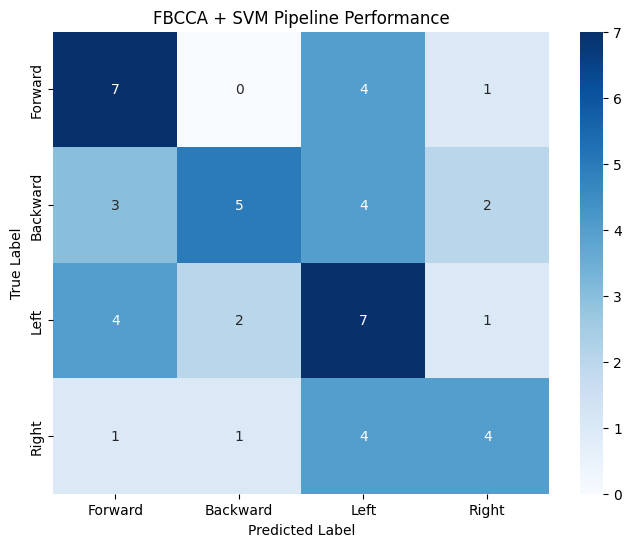

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter
from sklearn.cross_decomposition import CCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Configuration ---
COMPETITION_BASE_PATH = '/kaggle/input/mtcaic3/'
FS = 250
SSVEP_SAMPLES = 1750
TARGET_FREQS = {
    'Forward': 7.0, 'Backward': 8.0, 'Left': 10.0, 'Right': 13.0
}
LABELS = list(TARGET_FREQS.keys())
N_HARMONICS = 3
RELEVANT_CHANNELS = ['PZ', 'PO7', 'OZ', 'PO8']
FILTER_BANK = [
    (6, 14), (14, 22), (22, 30), (30, 38), (38, 46)
]
FILTER_WEIGHTS = [1.0, 1.0, 0.5, 0.5, 0.25]

# --- Core Functions ---
def load_trial_data(row, base_path, dataset_split):
    eeg_path = os.path.join(base_path, row['task'], dataset_split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    if not os.path.exists(eeg_path): return None
    eeg_data = pd.read_csv(eeg_path)
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * SSVEP_SAMPLES
    end_idx = start_idx + SSVEP_SAMPLES
    return eeg_data.iloc[start_idx:end_idx]

def preprocess_data(trial_df):
    return trial_df[RELEVANT_CHANNELS].values.T

def generate_reference_signals(freq, n_samples, n_harmonics):
    t = np.arange(n_samples) / FS
    references = []
    for h in range(1, n_harmonics + 1):
        harmonic_freq = freq * h
        references.append(np.sin(2 * np.pi * harmonic_freq * t))
        references.append(np.cos(2 * np.pi * harmonic_freq * t))
    return np.array(references).T

def extract_fbcca_features(eeg_signal):
    """
    MODIFIED: Instead of returning the predicted label, this now returns the
    vector of final correlation scores, which will be our features.
    """
    n_samples = eeg_signal.shape[1]
    feature_vector = np.zeros(len(TARGET_FREQS))
    cca = CCA(n_components=1)
    
    for i, (low, high) in enumerate(FILTER_BANK):
        b, a = butter(5, [low, high], btype='band', fs=FS)
        filtered_eeg = lfilter(b, a, eeg_signal, axis=1)
        correlations_for_this_band = []
        for freq in TARGET_FREQS.values():
            ref_signals = generate_reference_signals(freq, n_samples, N_HARMONICS)
            cca.fit(filtered_eeg.T, ref_signals)
            eeg_c, ref_c = cca.transform(filtered_eeg.T, ref_signals)
            corr = np.corrcoef(eeg_c[:, 0], ref_c[:, 0])[0, 1]
            correlations_for_this_band.append(corr)
        weight = FILTER_WEIGHTS[i]
        feature_vector += (weight * np.square(correlations_for_this_band))
        
    return feature_vector

# --- Main Pipeline Logic ---
if __name__ == '__main__':
    # 1. Load data index files
    train_df = pd.read_csv(os.path.join(COMPETITION_BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(COMPETITION_BASE_PATH, 'validation.csv'))

    ssvep_train_df = train_df[train_df['task'] == 'SSVEP']
    ssvep_validation_df = validation_df[validation_df['task'] == 'SSVEP']

    # 2. Extract FBCCA features for the training set
    print("Extracting FBCCA features from training data...")
    X_train_features = []
    y_train_labels = []
    for idx, row in ssvep_train_df.iterrows():
        trial_data = load_trial_data(row, COMPETITION_BASE_PATH, 'train')
        if trial_data is not None:
            preprocessed_eeg = preprocess_data(trial_data)
            features = extract_fbcca_features(preprocessed_eeg)
            X_train_features.append(features)
            y_train_labels.append(row['label'])
        print(f"  Processed training trial {idx + 1}/{len(ssvep_train_df)}", end='\r')
    
    X_train = np.array(X_train_features)
    y_train = np.array(y_train_labels)

    # 3. Extract FBCCA features for the validation set
    print("\nExtracting FBCCA features from validation data...")
    X_val_features = []
    y_val_labels = []
    for idx, row in ssvep_validation_df.iterrows():
        trial_data = load_trial_data(row, COMPETITION_BASE_PATH, 'validation')
        if trial_data is not None:
            preprocessed_eeg = preprocess_data(trial_data)
            features = extract_fbcca_features(preprocessed_eeg)
            X_val_features.append(features)
            y_val_labels.append(row['label'])
        print(f"  Processed validation trial {idx + 1}/{len(ssvep_validation_df)}", end='\r')

    X_val = np.array(X_val_features)
    y_val = np.array(y_val_labels)
    
    print(f"\n\nFeature extraction complete. Training features shape: {X_train.shape}")

    # 4. Train the SVM Classifier
    print("Training Support Vector Machine (SVM) classifier...")
    # We create a pipeline that first scales the data then trains the SVM.
    # An RBF kernel is excellent for capturing non-linear relationships.
    # C=10 is a good starting point for the regularization parameter.
    svm_pipeline = make_pipeline(
        StandardScaler(), 
        SVC(kernel='rbf', C=10, probability=True, random_state=42)
    )
    
    svm_pipeline.fit(X_train, y_train)
    print("Training complete.")

    # 5. Evaluate the pipeline on the validation set
    print("\nEvaluating pipeline on validation data...")
    y_pred = svm_pipeline.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"\n--- FBCCA + SVM Pipeline Results ---")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Validation F1-Score (Weighted): {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=LABELS))

    # Visualize the confusion matrix
    cm = confusion_matrix(y_val, y_pred, labels=LABELS)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('FBCCA + SVM Pipeline Performance')
    plt.show()



# The 50% accuracy better approach

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.signal import cheby1, filtfilt
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# --- Configuration & Constants ---
# Use the Kaggle directory structure
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250
SSVEP_FREQUENCIES = [7, 8, 10, 13] # Hz
CLASS_LABELS = ['Forward', 'Backward', 'Left', 'Right']
SAMPLES_PER_SSVEP_TRIAL = 1750 # 7 seconds * 250 Hz
NUM_HARMONICS = 3 # Increased to capture more harmonic information

# --- 1. Data Loading Function ---
def load_trial_data(row, base_path, dataset_type):
    """
    Loads raw EEG data for a single trial.
    """
    try:
        eeg_path = os.path.join(base_path, 'SSVEP', dataset_type, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        eeg_data = pd.read_csv(eeg_path)
        
        trial_num = int(row['trial'])
        start_idx = (trial_num - 1) * SAMPLES_PER_SSVEP_TRIAL
        end_idx = start_idx + SAMPLES_PER_SSVEP_TRIAL
        
        trial_eeg_data = eeg_data.loc[start_idx:end_idx-1, EEG_CHANNELS]
        return trial_eeg_data.values
    except FileNotFoundError:
        print(f"Error: File not found at {eeg_path}")
        return None

# --- 2. Reference Signal Generation ---
def get_reference_signals(duration_samples, frequencies, sampling_rate, num_harmonics):
    """
    Generates sine and cosine reference signals for each target frequency.
    """
    reference_signals = {}
    t = np.arange(duration_samples) / sampling_rate
    
    for freq in frequencies:
        refs = []
        for h in range(1, num_harmonics + 1):
            harmonic_freq = freq * h
            refs.append(np.sin(2 * np.pi * harmonic_freq * t))
            refs.append(np.cos(2 * np.pi * harmonic_freq * t))
        reference_signals[freq] = np.array(refs).T
    return reference_signals

# --- 3. Enhanced Filter Bank and Feature Extraction ---

# **IMPROVEMENT 1: More Precise Filter Bank**
# This new filter bank uses narrower, overlapping bands to improve frequency resolution.
# This helps to better isolate the target SSVEP frequencies from noise.
def get_enhanced_filterbank(sampling_rate):
    """
    Creates a more precise bank of 5 Chebyshev Type I bandpass filters.
    """
    # Bands are defined as [start_freq, end_freq]
    # Each band has a width of 8Hz, starting from 6Hz and incrementing by 8Hz
    # This creates overlapping filters that cover the full spectrum of interest.
    filter_bands = [[(i*8 + 6), (i*8 + 14)] for i in range(5)] # e.g., [6,14], [14,22], ... [38, 46]
    
    filters = []
    for (low, high) in filter_bands:
        nyquist = 0.5 * sampling_rate
        # Using a slightly higher order filter for sharper cutoff
        b, a = cheby1(5, 0.1, [low/nyquist, high/nyquist], btype='band')
        filters.append((b, a))
    return filters

# **IMPROVEMENT 2: Richer, Concatenated Feature Vector**
# Instead of summing the correlations, we now concatenate them to provide more
# detailed information to the classifier.
def get_fbcca_features(eeg_data, reference_signals, filters):
    """
    Extracts features for a single trial using the enhanced FBCCA method.
    The output is a concatenated vector of correlations from all filter banks.
    Args:
        eeg_data (np.ndarray): The raw EEG data for the trial [samples, channels].
        reference_signals (dict): The generated sine/cosine reference signals.
        filters (list): The list of filter coefficients from get_enhanced_filterbank.
    Returns:
        np.ndarray: A rich feature vector of concatenated CCA correlations (length = 20).
    """
    cca = CCA(n_components=1)
    # The final feature vector will contain the correlations for each frequency against each filter bank.
    # Total length = len(SSVEP_FREQUENCIES) * len(filters) = 4 * 5 = 20
    trial_feature_vector = []

    for freq in SSVEP_FREQUENCIES:
        ref_sig = reference_signals[freq]
        
        # Apply each filter in the bank and get the CCA correlation
        for b, a in filters:
            filtered_eeg = filtfilt(b, a, eeg_data, axis=0)
            cca.fit(filtered_eeg, ref_sig)
            X_c, Y_c = cca.transform(filtered_eeg, ref_sig)
            corr = np.corrcoef(X_c.ravel(), Y_c.ravel())[0, 1]
            trial_feature_vector.append(corr)
            
    return np.array(trial_feature_vector)


# --- 4. Main Execution Logic ---
if __name__ == '__main__':
    print("Starting SSVEP Classification Pipeline with ENHANCED features...")

    # Load index files
    try:
        train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
        validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    except FileNotFoundError:
        print(f"Error: Competition CSV files not found in {BASE_PATH}. Please check the path.")
        exit()

    # Filter for SSVEP task only
    train_ssvep_df = train_df[train_df['task'] == 'SSVEP'].reset_index(drop=True)
    validation_ssvep_df = validation_df[validation_df['task'] == 'SSVEP'].reset_index(drop=True)

    # --- Pre-computation ---
    print("Pre-computing reference signals and enhanced filter bank...")
    reference_signals = get_reference_signals(SAMPLES_PER_SSVEP_TRIAL, SSVEP_FREQUENCIES, SAMPLING_RATE, NUM_HARMONICS)
    filters = get_enhanced_filterbank(SAMPLING_RATE)
    # The fb_weights are no longer needed as we are concatenating features.

    # --- Feature Extraction and Normalization for TRAINING data ---
    print("Extracting features from training data...")
    X_train = []
    y_train = []
    subjects_train = []
    
    for idx, row in train_ssvep_df.iterrows():
        eeg_trial = load_trial_data(row, BASE_PATH, 'train')
        if eeg_trial is not None:
            # Use the new feature extraction function
            features = get_fbcca_features(eeg_trial, reference_signals, filters)
            X_train.append(features)
            y_train.append(row['label'])
            subjects_train.append(row['subject_id'])
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    subjects_train = np.array(subjects_train)

    # **CRITICAL STEP: Per-Subject Normalization for Training Data**
    print("Applying per-subject normalization to training features...")
    X_train_normalized = np.zeros_like(X_train)
    subject_scalers = {}

    for subject_id in np.unique(subjects_train):
        subject_indices = np.where(subjects_train == subject_id)[0]
        subject_features = X_train[subject_indices]
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(subject_features)
        X_train_normalized[subject_indices] = scaled_features
        subject_scalers[subject_id] = scaler

    # --- Feature Extraction and Normalization for VALIDATION data ---
    print("Extracting features from validation data...")
    X_val = []
    y_val = []
    subjects_val = []

    for idx, row in validation_ssvep_df.iterrows():
        eeg_trial = load_trial_data(row, BASE_PATH, 'validation')
        if eeg_trial is not None:
            features = get_fbcca_features(eeg_trial, reference_signals, filters)
            X_val.append(features)
            y_val.append(row['label'])
            subjects_val.append(row['subject_id'])
            
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    subjects_val = np.array(subjects_val)

    # **CRITICAL STEP: Per-Subject Normalization for Validation Data**
    print("Applying per-subject normalization to validation features...")
    X_val_normalized = np.zeros_like(X_val)

    for subject_id in np.unique(subjects_val):
        subject_indices = np.where(subjects_val == subject_id)[0]
        subject_features = X_val[subject_indices]
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(subject_features)
        X_val_normalized[subject_indices] = scaled_features


    # --- 5. Model Training and Evaluation ---
    print("\n--- Model Training and Evaluation ---")
    lda_model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    
    print("Training LDA model...")
    lda_model.fit(X_train_normalized, y_train)

    # --- Evaluation ---
    print("\n--- Results on Validation Set ---")
    predictions = lda_model.predict(X_val_normalized)
    
    accuracy = accuracy_score(y_val, predictions)
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_val, predictions, target_names=CLASS_LABELS))


# Tier 1 leave one subject out cross validation + xgboost

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings

# --- Tier 1 Imports: Add classifiers and LabelEncoder ---
from scipy.signal import cheby1, filtfilt
from scipy.linalg import eigh
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Import the classifiers we will test
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
import lightgbm as lgb


# --- Configuration & Constants ---
warnings.filterwarnings('ignore')

# Use the Kaggle directory structure
BASE_PATH = '/kaggle/input/mtcaic3'

# --- Tier 1 Mod: Classifier Selection ---
# Change this variable to 'XGBoost', 'LGBM', 'SVC', or 'LDA' to test different models.
CLASSIFIER_TO_USE = 'XGBoost'

# --- Tier 1 Mod: Easily Tunable Time Window ---
# Experiment with these values to find the optimal signal segment.
# The original paper on TRCA found that shorter windows (e.g., 0.5s) can be effective.
TRIAL_TOTAL_DURATION = 7.0  # seconds in the original file
SKIP_DURATION = 1.0         # Seconds to skip from the beginning of each trial (removes onset artifacts)
DATA_DURATION = 5.0         # Seconds of data to actually use for analysis (the "sweet spot")

# --- Core EEG & SSVEP Constants ---
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250
SSVEP_FREQUENCIES_MAP = {'Forward': 7, 'Backward': 8, 'Left': 10, 'Right': 13}
CLASS_LABELS = list(SSVEP_FREQUENCIES_MAP.keys())
SSVEP_FREQUENCIES_LIST = list(SSVEP_FREQUENCIES_MAP.values())
NUM_HARMONICS = 3

# Calculated sample counts based on the time window
SAMPLES_PER_TRIAL_FULL = int(TRIAL_TOTAL_DURATION * SAMPLING_RATE)
SAMPLES_TO_SKIP = int(SKIP_DURATION * SAMPLING_RATE)
SAMPLES_PER_SSVEP_TRIAL = int(DATA_DURATION * SAMPLING_RATE)


# --- 1. Data Loading and Preprocessing ---
def load_trial_data(row, base_path, dataset_type):
    """
    Loads raw EEG data for a single trial, applying the specified time window to skip initial artifacts.
    """
    try:
        path_segment = dataset_type
        eeg_path = os.path.join(base_path, 'SSVEP', path_segment, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        eeg_data = pd.read_csv(eeg_path)
        
        trial_num = int(row['trial'])
        
        # Calculate start/end indices based on the refined time window
        trial_start_in_file = (trial_num - 1) * SAMPLES_PER_TRIAL_FULL
        start_idx = trial_start_in_file + SAMPLES_TO_SKIP
        end_idx = start_idx + SAMPLES_PER_SSVEP_TRIAL
        
        trial_eeg_data = eeg_data.loc[start_idx:end_idx-1, EEG_CHANNELS]
        return trial_eeg_data.values
    except FileNotFoundError:
        print(f"Error: EEGdata.csv not found at {eeg_path}")
        return None

# --- 2. Feature Engineering Functions ---

# --- Tier 1 Mod: Refined Filter Bank ---
def get_refined_filterbank():
    """
    Creates a bank of 5 narrow, systematic Chebyshev Type I bandpass filters.
    This refined bank provides better frequency resolution to isolate SSVEP signals.
    """
    filter_bands = []
    # Create 5 bands of 8Hz width, starting from 6Hz and incrementing by 8Hz.
    # This systematically covers the spectrum from 6Hz to 46Hz.
    # Example: [6-14Hz], [14-22Hz], [22-30Hz], [30-38Hz], [38-46Hz]
    for i in range(5):
        low_freq = 6 + i * 8
        high_freq = low_freq + 8
        filter_bands.append([low_freq, high_freq])
        
    filters = []
    for (low, high) in filter_bands:
        nyquist = 0.5 * SAMPLING_RATE
        # A filter order of 5 provides a good balance of sharpness and stability.
        b, a = cheby1(5, 0.1, [low/nyquist, high/nyquist], btype='band')
        filters.append((b, a))
    return filters

def apply_filterbank(eeg_data, filters):
    """Applies each filter in the bank to the EEG data."""
    return np.array([filtfilt(b, a, eeg_data, axis=0) for b, a in filters])

def get_reference_signals(duration_samples, frequencies):
    """
    Generates sine and cosine reference signals for each target frequency and its harmonics.
    """
    reference_signals = {}
    t = np.arange(duration_samples) / SAMPLING_RATE
    
    for freq in frequencies:
        refs = []
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = freq * h
            refs.append(np.sin(2 * np.pi * harmonic_freq * t))
            refs.append(np.cos(2 * np.pi * harmonic_freq * t))
        reference_signals[freq] = np.array(refs).T
    return reference_signals

def get_fbcca_features(filtered_eeg_bank, reference_signals):
    """
    Extracts features using the Filter-Bank CCA (FBCCA) method.
    """
    cca = CCA(n_components=1)
    fb_feature_vector = []

    for filtered_eeg in filtered_eeg_bank:
        rho_k = []
        for freq in SSVEP_FREQUENCIES_LIST:
            ref_sig = reference_signals[freq]
            cca.fit(filtered_eeg, ref_sig)
            X_c, Y_c = cca.transform(filtered_eeg, ref_sig)
            # Handle potential NaN values in correlation
            corr = np.corrcoef(X_c.ravel(), Y_c.ravel())[0, 1]
            rho_k.append(corr if np.isfinite(corr) else 0)
        fb_feature_vector.extend(rho_k)
            
    return np.array(fb_feature_vector)

def get_trca_spatial_filters(X_train, y_train, labels):
    """
    Computes Task-Related Component Analysis (TRCA) spatial filters.
    These filters maximize the reproducibility (consistency) of the signal for each class.
    """
    spatial_filters = {}
    unique_labels = np.unique(y_train)

    for label in labels:
        if label not in unique_labels:
            spatial_filters[label] = np.zeros(X_train.shape[2]) # Return zero vector if class not in fold
            continue

        class_trials = X_train[y_train == label]
        
        if class_trials.shape[0] < 2: # Need at least 2 trials to compute covariance
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
            continue

        class_trials_centered = class_trials - np.mean(class_trials, axis=1, keepdims=True)
        
        S = np.zeros((X_train.shape[2], X_train.shape[2]))
        for i in range(class_trials_centered.shape[0]):
            S += np.cov(class_trials_centered[i,:,:].T)

        sum_of_trials = np.sum(class_trials_centered, axis=0)
        Q = np.cov(sum_of_trials.T)
        
        try:
            # Solve the generalized eigenvalue problem: Qw = λSw
            evals, evecs = eigh(Q, S)
            spatial_filters[label] = evecs[:, -1] # Eigenvector for the largest eigenvalue
        except np.linalg.LinAlgError:
            # Fallback for singular matrix S
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
            
    return spatial_filters

def extract_trca_features(eeg_trial, spatial_filters):
    """
    Extracts features for a single trial using the learned TRCA spatial filters.
    """
    features = []
    # Create class template signals by applying the learned filters
    templates = {label: eeg_trial @ w for label, w in spatial_filters.items()}
    
    for label, w in spatial_filters.items():
        projected_eeg = eeg_trial @ w
        # Correlate the projected signal with each class template
        corr = np.corrcoef(projected_eeg, templates[label])[0, 1]
        features.append(corr if np.isfinite(corr) else 0)
        
    return np.array(features)

# --- 3. Main Execution Logic ---
if __name__ == '__main__':
    print(f"--- Starting SSVEP Hybrid Pipeline ---")
    print(f"Classifier selected: {CLASSIFIER_TO_USE}")
    print(f"Time window: Skip {SKIP_DURATION}s, Use {DATA_DURATION}s")

    # Load competition index files
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Combine train and validation sets for robust cross-validation
    full_train_df = pd.concat([
        train_df[train_df['task'] == 'SSVEP'],
        validation_df[validation_df['task'] == 'SSVEP']
    ]).reset_index(drop=True)

    # --- Pre-computation ---
    print("\nPre-computing reference signals and refined filter bank...")
    reference_signals = get_reference_signals(SAMPLES_PER_SSVEP_TRIAL, SSVEP_FREQUENCIES_LIST)
    filters = get_refined_filterbank() # Using the new refined filter bank
    
    # --- Load All Training Data ---
    print("Loading all training & validation data...")
    X_all = [load_trial_data(row, BASE_PATH, 'train' if row['id'] <= 4800 else 'validation') for _, row in full_train_df.iterrows()]
    X_all = np.array([x for x in X_all if x is not None and x.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS))])
    
    y_all = full_train_df['label'].values
    subjects_all = full_train_df['subject_id'].values

    # --- Tier 1 Mod: Label Encoding for XGBoost/LGBM ---
    # Classifiers like XGBoost require integer labels instead of strings
    le = LabelEncoder()
    y_all_encoded = le.fit_transform(y_all)
    
    print("\nPre-computing all features... (This may take a moment)")
    all_fbcca_features = np.array([get_fbcca_features(apply_filterbank(trial, filters), reference_signals) for trial in X_all])
    all_trca_filters_for_features = get_trca_spatial_filters(X_all, y_all, CLASS_LABELS)
    all_trca_features = np.array([extract_trca_features(trial, all_trca_filters_for_features) for trial in X_all])
    all_hybrid_features = np.concatenate([all_trca_features, all_fbcca_features], axis=1)
    print("Feature pre-computation complete.")

    # --- Leave-One-Subject-Out Cross-Validation ---
    print("\n--- Starting Leave-One-Subject-Out Cross-Validation ---")
    logo = LeaveOneGroupOut()
    all_predictions = []
    all_true_labels = []

    # --- Tier 1 Mod: Define models and hyperparameter grids in one place ---
    models = {
        'XGBoost': (xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.05, 0.1]
        }),
        'LGBM': (lgb.LGBMClassifier(random_state=42), {
            'n_estimators': [100, 200],
            'num_leaves': [20, 31],
            'learning_rate': [0.05, 0.1]
        }),
        'SVC': (SVC(probability=True, random_state=42), {
            'C': [10, 50, 100],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf'] 
        }),
        'LDA': (LinearDiscriminantAnalysis(), {
            'solver': ['lsqr'],
            'shrinkage': ['auto', 0.1, 0.5, 0.9]
        })
    }
    
    model_to_run, param_grid = models[CLASSIFIER_TO_USE]

    for fold_idx, (train_idx, val_idx) in enumerate(logo.split(all_hybrid_features, y_all_encoded, groups=subjects_all)):
        val_subject = subjects_all[val_idx][0]
        print(f"Fold {fold_idx+1}/{len(np.unique(subjects_all))}: Validating on subject {val_subject}")

        # Split features and labels for this fold
        X_train_fold, X_val_fold = all_hybrid_features[train_idx], all_hybrid_features[val_idx]
        y_train_fold, y_val_fold = y_all_encoded[train_idx], y_all_encoded[val_idx] # Use encoded labels
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # Hyperparameter tuning for the selected model
        grid_search = GridSearchCV(
            estimator=model_to_run,
            param_grid=param_grid,
            scoring='accuracy',
            cv=3, # 3-fold CV within the training set of each LOSO fold
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train_scaled, y_train_fold)
        best_model = grid_search.best_estimator_
        
        # Store predictions
        predictions_encoded = best_model.predict(X_val_scaled)
        all_predictions.extend(predictions_encoded)
        all_true_labels.extend(y_val_fold)

    # --- Overall Cross-Validation Results ---
    print("\n--- Overall LOSO Cross-Validation Results ---")
    # Decode labels back to strings for the report
    all_true_str = le.inverse_transform(all_true_labels)
    all_predictions_str = le.inverse_transform(all_predictions)
    
    overall_accuracy = accuracy_score(all_true_str, all_predictions_str)
    print(f"Overall LOSO CV Accuracy: {overall_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_true_str, all_predictions_str, target_names=CLASS_LABELS))
    
    # --- Final Model Training and Submission File Generation ---
    print("\n--- Training Final Model on All Data for Submission ---")
    
    # Scale all features
    final_scaler = StandardScaler()
    X_all_scaled = final_scaler.fit_transform(all_hybrid_features)
    
    # Re-run grid search on all data to find the absolute best parameters
    print("Finding best hyperparameters for the final model...")
    final_grid_search = GridSearchCV(estimator=model_to_run, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
    final_grid_search.fit(X_all_scaled, y_all_encoded)
    final_model = final_grid_search.best_estimator_
    print(f"Final model trained with best parameters: {final_grid_search.best_params_}")
    
    print("\nGenerating predictions for the test set...")
    test_ssvep_df = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)
    test_predictions_list = []

    for idx, row in test_ssvep_df.iterrows():
        eeg_trial = load_trial_data(row, BASE_PATH, 'test')
        if eeg_trial is not None and eeg_trial.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            # Extract features for the test trial
            fbcca_feat = get_fbcca_features(apply_filterbank(eeg_trial, filters), reference_signals).reshape(1, -1)
            trca_feat = extract_trca_features(eeg_trial, all_trca_filters_for_features).reshape(1, -1)
            X_test_hybrid = np.concatenate([trca_feat, fbcca_feat], axis=1)
            
            # Scale and predict
            X_test_scaled = final_scaler.transform(X_test_hybrid)
            prediction_encoded = final_model.predict(X_test_scaled)[0]
            test_predictions_list.append(prediction_encoded)
        else:
            # Fallback: predict the most frequent class if data is missing/corrupt
            most_frequent_class_encoded = le.transform([pd.Series(y_all).mode()[0]])[0]
            test_predictions_list.append(most_frequent_class_encoded)

    # Decode predictions and create submission file
    final_predictions_str = le.inverse_transform(test_predictions_list)
    submission_df = pd.DataFrame({'id': test_ssvep_df['id'], 'label': final_predictions_str})
    submission_df.to_csv('/kaggle/working/submission.csv', index=False)
    
    print("\nSubmission file 'submission.csv' has been created successfully!")
    print(submission_df.head())



# New feature type + Voting ensemble (67% accuracy)

New Feature Type - Power Spectral Density (PSD): I've added a new function, get_psd_features, which calculates the signal power at the precise target frequencies and their harmonics for each EEG channel. This provides a completely new source of information for the model, complementing the correlation-based features. The final feature set now combines TRCA + FBCCA + PSD.
Ensemble Classifier (VotingClassifier): Instead of relying on a single model, this script now uses a VotingClassifier. This powerful technique combines the predictions from three different models (XGBoost, SVC, and LDA). By averaging their "votes" (specifically, their predicted probabilities), the ensemble can produce a more robust and accurate final decision, smoothing out the errors of any single model.

In [1]:
import pandas as pd
import numpy as np
import os
import warnings

# --- Tier 2 Imports: Welch for PSD, VotingClassifier for Ensembling ---
from scipy.signal import cheby1, filtfilt, welch
from scipy.linalg import eigh
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report

# Import the classifiers for the ensemble
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import VotingClassifier


# --- Configuration & Constants ---
warnings.filterwarnings('ignore')

BASE_PATH = '/kaggle/input/mtcaic3'

# Time window configuration
TRIAL_TOTAL_DURATION = 7.0
SKIP_DURATION = 1.0
DATA_DURATION = 5.0

# Core EEG & SSVEP Constants
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250
SSVEP_FREQUENCIES_MAP = {'Forward': 7, 'Backward': 8, 'Left': 10, 'Right': 13}
CLASS_LABELS = list(SSVEP_FREQUENCIES_MAP.keys())
SSVEP_FREQUENCIES_LIST = list(SSVEP_FREQUENCIES_MAP.values())
NUM_HARMONICS = 3

# Calculated sample counts
SAMPLES_PER_TRIAL_FULL = int(TRIAL_TOTAL_DURATION * SAMPLING_RATE)
SAMPLES_TO_SKIP = int(SKIP_DURATION * SAMPLING_RATE)
SAMPLES_PER_SSVEP_TRIAL = int(DATA_DURATION * SAMPLING_RATE)


# --- 1. Data Loading Function (Unchanged) ---
def load_trial_data(row, base_path, dataset_type):
    """
    Loads raw EEG data for a single trial, applying the specified time window.
    """
    try:
        path_segment = dataset_type
        eeg_path = os.path.join(base_path, 'SSVEP', path_segment, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        eeg_data = pd.read_csv(eeg_path)
        trial_num = int(row['trial'])
        trial_start_in_file = (trial_num - 1) * SAMPLES_PER_TRIAL_FULL
        start_idx = trial_start_in_file + SAMPLES_TO_SKIP
        end_idx = start_idx + SAMPLES_PER_SSVEP_TRIAL
        trial_eeg_data = eeg_data.loc[start_idx:end_idx-1, EEG_CHANNELS]
        return trial_eeg_data.values
    except FileNotFoundError:
        print(f"Error: EEGdata.csv not found at {eeg_path}")
        return None

# --- 2. Feature Engineering Functions ---

# --- Tier 2 New Feature: Power Spectral Density (PSD) ---
def get_psd_features(eeg_trial):
    """
    Calculates Power Spectral Density (PSD) features for a trial.
    This captures the power of the signal at key frequencies.
    """
    psd_features = []
    
    # Define a narrow band for extracting power around the target frequencies
    freq_band_width = 0.5 # Hz
    
    for channel_data in eeg_trial.T: # Iterate through each of the 8 channels
        freqs, psd = welch(channel_data, fs=SAMPLING_RATE, nperseg=SAMPLES_PER_SSVEP_TRIAL)
        
        # For each target frequency, calculate the average power in a narrow band around it and its harmonics
        for target_freq in SSVEP_FREQUENCIES_LIST:
            for h in range(1, NUM_HARMONICS + 1):
                harmonic_freq = target_freq * h
                band_mask = (freqs >= harmonic_freq - freq_band_width) & (freqs <= harmonic_freq + freq_band_width)
                
                if np.any(band_mask):
                    avg_power = np.mean(psd[band_mask])
                    psd_features.append(avg_power)
                else:
                    psd_features.append(0) # Append 0 if the frequency is not found
                    
    return np.array(psd_features)


# --- FBCCA and TRCA Functions (Unchanged from Tier 1) ---
def get_refined_filterbank():
    filter_bands = [[6 + i * 8, 14 + i * 8] for i in range(5)]
    filters = []
    for (low, high) in filter_bands:
        b, a = cheby1(5, 0.1, [low/(0.5*SAMPLING_RATE), high/(0.5*SAMPLING_RATE)], btype='band')
        filters.append((b, a))
    return filters

def apply_filterbank(eeg_data, filters):
    return np.array([filtfilt(b, a, eeg_data, axis=0) for b, a in filters])

def get_reference_signals(duration_samples, frequencies):
    reference_signals = {}
    t = np.arange(duration_samples) / SAMPLING_RATE
    for freq in frequencies:
        refs = []
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = freq * h
            refs.extend([np.sin(2 * np.pi * harmonic_freq * t), np.cos(2 * np.pi * harmonic_freq * t)])
        reference_signals[freq] = np.array(refs).T
    return reference_signals

def get_fbcca_features(filtered_eeg_bank, reference_signals):
    cca = CCA(n_components=1)
    fb_feature_vector = []
    for filtered_eeg in filtered_eeg_bank:
        rho_k = []
        for freq in SSVEP_FREQUENCIES_LIST:
            ref_sig = reference_signals[freq]
            cca.fit(filtered_eeg, ref_sig)
            X_c, Y_c = cca.transform(filtered_eeg, ref_sig)
            corr = np.corrcoef(X_c.ravel(), Y_c.ravel())[0, 1]
            rho_k.append(corr if np.isfinite(corr) else 0)
        fb_feature_vector.extend(rho_k)
    return np.array(fb_feature_vector)

def get_trca_spatial_filters(X_train, y_train, labels):
    spatial_filters = {}
    unique_labels = np.unique(y_train)
    for label in labels:
        if label not in unique_labels:
            spatial_filters[label] = np.zeros(X_train.shape[2])
            continue
        class_trials = X_train[y_train == label]
        if class_trials.shape[0] < 2:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
            continue
        class_trials_centered = class_trials - np.mean(class_trials, axis=1, keepdims=True)
        S = np.sum([np.cov(trial.T) for trial in class_trials_centered], axis=0)
        Q = np.cov(np.sum(class_trials_centered, axis=0).T)
        try:
            evals, evecs = eigh(Q, S)
            spatial_filters[label] = evecs[:, -1]
        except np.linalg.LinAlgError:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
    return spatial_filters

def extract_trca_features(eeg_trial, spatial_filters):
    features = []
    templates = {label: eeg_trial @ w for label, w in spatial_filters.items()}
    for label, w in spatial_filters.items():
        projected_eeg = eeg_trial @ w
        corr = np.corrcoef(projected_eeg, templates[label])[0, 1]
        features.append(corr if np.isfinite(corr) else 0)
    return np.array(features)


# --- 3. Main Execution Logic ---
if __name__ == '__main__':
    print("--- Starting SSVEP Pipeline: Tier 2 (Ensemble + PSD Features) ---")

    # Load competition index files
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    full_train_df = pd.concat([
        train_df[train_df['task'] == 'SSVEP'],
        validation_df[validation_df['task'] == 'SSVEP']
    ]).reset_index(drop=True)

    print("\nPre-computing references and filters...")
    reference_signals = get_reference_signals(SAMPLES_PER_SSVEP_TRIAL, SSVEP_FREQUENCIES_LIST)
    filters = get_refined_filterbank()
    
    print("Loading all training & validation data...")
    X_all_raw = [load_trial_data(row, BASE_PATH, 'train' if row['id'] <= 4800 else 'validation') for _, row in full_train_df.iterrows()]
    
    # Filter out None values and create final arrays
    valid_indices = [i for i, x in enumerate(X_all_raw) if x is not None and x.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS))]
    X_all = np.array([X_all_raw[i] for i in valid_indices])
    y_all = full_train_df.loc[valid_indices, 'label'].values
    subjects_all = full_train_df.loc[valid_indices, 'subject_id'].values

    le = LabelEncoder()
    y_all_encoded = le.fit_transform(y_all)
    
    print("\nPre-computing all features (TRCA, FBCCA, PSD)...")
    # FBCCA features
    all_fbcca_features = np.array([get_fbcca_features(apply_filterbank(trial, filters), reference_signals) for trial in X_all])
    # TRCA features
    all_trca_filters_for_features = get_trca_spatial_filters(X_all, y_all, CLASS_LABELS)
    all_trca_features = np.array([extract_trca_features(trial, all_trca_filters_for_features) for trial in X_all])
    # PSD features
    all_psd_features = np.array([get_psd_features(trial) for trial in X_all])
    
    # --- Tier 2 Feature Concatenation ---
    all_features_combined = np.concatenate([all_trca_features, all_fbcca_features, all_psd_features], axis=1)
    print(f"Feature engineering complete. Total feature dimension: {all_features_combined.shape[1]}")

    # --- Tier 2 Ensemble Model Definition ---
    print("\nDefining Ensemble Classifier...")
    # Base models for the ensemble. Parameters are set to reasonable defaults or values found from Tier 1.
    clf1 = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', learning_rate=0.1, max_depth=3, n_estimators=100)
    clf2 = SVC(probability=True, random_state=42, C=50, kernel='rbf', gamma='scale')
    clf3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

    # Create the Voting Classifier
    # 'soft' voting uses predicted probabilities, which is often better than 'hard' (majority rule).
    ensemble_model = VotingClassifier(
        estimators=[('xgb', clf1), ('svc', clf2), ('lda', clf3)],
        voting='soft',
        weights=[0.4, 0.4, 0.2] # Give more weight to the more powerful models
    )
    
    # --- Leave-One-Subject-Out Cross-Validation with the Ensemble ---
    print("\n--- Starting LOSO Cross-Validation with Ensemble Model ---")
    logo = LeaveOneGroupOut()
    all_predictions_encoded = []
    all_true_labels_encoded = []

    for fold_idx, (train_idx, val_idx) in enumerate(logo.split(all_features_combined, y_all_encoded, groups=subjects_all)):
        val_subject = subjects_all[val_idx][0]
        print(f"Fold {fold_idx+1}/{len(np.unique(subjects_all))}: Validating on subject {val_subject}")

        X_train_fold, X_val_fold = all_features_combined[train_idx], all_features_combined[val_idx]
        y_train_fold = y_all_encoded[train_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # Fit the entire ensemble model
        ensemble_model.fit(X_train_scaled, y_train_fold)
        
        predictions_encoded = ensemble_model.predict(X_val_scaled)
        all_predictions_encoded.extend(predictions_encoded)
        all_true_labels_encoded.extend(y_all_encoded[val_idx])

    # --- Overall Cross-Validation Results ---
    print("\n--- Overall LOSO CV Results for Ensemble Model ---")
    all_true_str = le.inverse_transform(all_true_labels_encoded)
    all_predictions_str = le.inverse_transform(all_predictions_encoded)
    
    overall_accuracy = accuracy_score(all_true_str, all_predictions_str)
    print(f"Overall LOSO CV Accuracy: {overall_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_true_str, all_predictions_str, target_names=CLASS_LABELS))
    
    # --- Final Model Training and Submission ---
    print("\n--- Training Final Ensemble Model on All Data for Submission ---")
    
    final_scaler = StandardScaler()
    X_all_scaled = final_scaler.fit_transform(all_features_combined)
    
    ensemble_model.fit(X_all_scaled, y_all_encoded)
    print("Final ensemble model training complete.")
    
    print("\nGenerating predictions for the test set...")
    test_ssvep_df = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)
    test_predictions_list = []

    for idx, row in test_ssvep_df.iterrows():
        eeg_trial = load_trial_data(row, BASE_PATH, 'test')
        if eeg_trial is not None and eeg_trial.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            fbcca_feat = get_fbcca_features(apply_filterbank(eeg_trial, filters), reference_signals).reshape(1, -1)
            trca_feat = extract_trca_features(eeg_trial, all_trca_filters_for_features).reshape(1, -1)
            psd_feat = get_psd_features(eeg_trial).reshape(1, -1)
            
            X_test_combined = np.concatenate([trca_feat, fbcca_feat, psd_feat], axis=1)
            
            X_test_scaled = final_scaler.transform(X_test_combined)
            prediction_encoded = ensemble_model.predict(X_test_scaled)[0]
            test_predictions_list.append(prediction_encoded)
        else:
            most_frequent_class_encoded = le.transform([pd.Series(y_all).mode()[0]])[0]
            test_predictions_list.append(most_frequent_class_encoded)

    final_predictions_str = le.inverse_transform(test_predictions_list)
    submission_df = pd.DataFrame({'id': test_ssvep_df['id'], 'label': final_predictions_str})
    submission_df.to_csv('/kaggle/working/submission.csv', index=False)
    
    print("\nSubmission file 'submission.csv' has been created successfully!")
    print(submission_df.head())

--- Starting SSVEP Pipeline: Tier 2 (Ensemble + PSD Features) ---

Pre-computing references and filters...
Loading all training & validation data...

Pre-computing all features (TRCA, FBCCA, PSD)...
Feature engineering complete. Total feature dimension: 120

Defining Ensemble Classifier...

--- Starting LOSO Cross-Validation with Ensemble Model ---
Fold 1/35: Validating on subject S1
Fold 2/35: Validating on subject S10
Fold 3/35: Validating on subject S11
Fold 4/35: Validating on subject S12
Fold 5/35: Validating on subject S13
Fold 6/35: Validating on subject S14
Fold 7/35: Validating on subject S15
Fold 8/35: Validating on subject S16
Fold 9/35: Validating on subject S17
Fold 10/35: Validating on subject S18
Fold 11/35: Validating on subject S19
Fold 12/35: Validating on subject S2
Fold 13/35: Validating on subject S20
Fold 14/35: Validating on subject S21
Fold 15/35: Validating on subject S22
Fold 16/35: Validating on subject S23
Fold 17/35: Validating on subject S24
Fold 18/35: Va

# The following code prints the confusion matrix of each subject

In [1]:
import pandas as pd
import numpy as np
import os
import warnings

# --- Tier 2 Imports: Welch for PSD, VotingClassifier for Ensembling ---
from scipy.signal import cheby1, filtfilt, welch
from scipy.linalg import eigh
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
# MODIFICATION START: Import additional metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
# MODIFICATION END

# Import the classifiers for the ensemble
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import VotingClassifier


# --- Configuration & Constants ---
warnings.filterwarnings('ignore')

BASE_PATH = '/kaggle/input/mtcaic3'

# Time window configuration
TRIAL_TOTAL_DURATION = 7.0
SKIP_DURATION = 1.0
DATA_DURATION = 5.0

# Core EEG & SSVEP Constants
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250
SSVEP_FREQUENCIES_MAP = {'Forward': 7, 'Backward': 8, 'Left': 10, 'Right': 13}
CLASS_LABELS = list(SSVEP_FREQUENCIES_MAP.keys())
SSVEP_FREQUENCIES_LIST = list(SSVEP_FREQUENCIES_MAP.values())
NUM_HARMONICS = 3

# Calculated sample counts
SAMPLES_PER_TRIAL_FULL = int(TRIAL_TOTAL_DURATION * SAMPLING_RATE)
SAMPLES_TO_SKIP = int(SKIP_DURATION * SAMPLING_RATE)
SAMPLES_PER_SSVEP_TRIAL = int(DATA_DURATION * SAMPLING_RATE)


# --- 1. Data Loading Function (Unchanged) ---
def load_trial_data(row, base_path, dataset_type):
    """
    Loads raw EEG data for a single trial, applying the specified time window.
    """
    try:
        path_segment = dataset_type
        eeg_path = os.path.join(base_path, 'SSVEP', path_segment, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        eeg_data = pd.read_csv(eeg_path)
        trial_num = int(row['trial'])
        trial_start_in_file = (trial_num - 1) * SAMPLES_PER_TRIAL_FULL
        start_idx = trial_start_in_file + SAMPLES_TO_SKIP
        end_idx = start_idx + SAMPLES_PER_SSVEP_TRIAL
        trial_eeg_data = eeg_data.loc[start_idx:end_idx-1, EEG_CHANNELS]
        return trial_eeg_data.values
    except FileNotFoundError:
        print(f"Error: EEGdata.csv not found at {eeg_path}")
        return None

# --- 2. Feature Engineering Functions ---

# --- Tier 2 New Feature: Power Spectral Density (PSD) ---
def get_psd_features(eeg_trial):
    """
    Calculates Power Spectral Density (PSD) features for a trial.
    This captures the power of the signal at key frequencies.
    """
    psd_features = []
    
    # Define a narrow band for extracting power around the target frequencies
    freq_band_width = 0.5 # Hz
    
    for channel_data in eeg_trial.T: # Iterate through each of the 8 channels
        freqs, psd = welch(channel_data, fs=SAMPLING_RATE, nperseg=SAMPLES_PER_SSVEP_TRIAL)
        
        # For each target frequency, calculate the average power in a narrow band around it and its harmonics
        for target_freq in SSVEP_FREQUENCIES_LIST:
            for h in range(1, NUM_HARMONICS + 1):
                harmonic_freq = target_freq * h
                band_mask = (freqs >= harmonic_freq - freq_band_width) & (freqs <= harmonic_freq + freq_band_width)
                
                if np.any(band_mask):
                    avg_power = np.mean(psd[band_mask])
                    psd_features.append(avg_power)
                else:
                    psd_features.append(0) # Append 0 if the frequency is not found
                    
    return np.array(psd_features)


# --- FBCCA and TRCA Functions (Unchanged from Tier 1) ---
def get_refined_filterbank():
    filter_bands = [[6 + i * 8, 14 + i * 8] for i in range(5)]
    filters = []
    for (low, high) in filter_bands:
        b, a = cheby1(5, 0.1, [low/(0.5*SAMPLING_RATE), high/(0.5*SAMPLING_RATE)], btype='band')
        filters.append((b, a))
    return filters

def apply_filterbank(eeg_data, filters):
    return np.array([filtfilt(b, a, eeg_data, axis=0) for b, a in filters])

def get_reference_signals(duration_samples, frequencies):
    reference_signals = {}
    t = np.arange(duration_samples) / SAMPLING_RATE
    for freq in frequencies:
        refs = []
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = freq * h
            refs.extend([np.sin(2 * np.pi * harmonic_freq * t), np.cos(2 * np.pi * harmonic_freq * t)])
        reference_signals[freq] = np.array(refs).T
    return reference_signals

def get_fbcca_features(filtered_eeg_bank, reference_signals):
    cca = CCA(n_components=1)
    fb_feature_vector = []
    for filtered_eeg in filtered_eeg_bank:
        rho_k = []
        for freq in SSVEP_FREQUENCIES_LIST:
            ref_sig = reference_signals[freq]
            cca.fit(filtered_eeg, ref_sig)
            X_c, Y_c = cca.transform(filtered_eeg, ref_sig)
            corr = np.corrcoef(X_c.ravel(), Y_c.ravel())[0, 1]
            rho_k.append(corr if np.isfinite(corr) else 0)
        fb_feature_vector.extend(rho_k)
    return np.array(fb_feature_vector)

def get_trca_spatial_filters(X_train, y_train, labels):
    spatial_filters = {}
    unique_labels = np.unique(y_train)
    for label in labels:
        if label not in unique_labels:
            spatial_filters[label] = np.zeros(X_train.shape[2])
            continue
        class_trials = X_train[y_train == label]
        if class_trials.shape[0] < 2:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
            continue
        class_trials_centered = class_trials - np.mean(class_trials, axis=1, keepdims=True)
        S = np.sum([np.cov(trial.T) for trial in class_trials_centered], axis=0)
        Q = np.cov(np.sum(class_trials_centered, axis=0).T)
        try:
            evals, evecs = eigh(Q, S)
            spatial_filters[label] = evecs[:, -1]
        except np.linalg.LinAlgError:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
    return spatial_filters

def extract_trca_features(eeg_trial, spatial_filters):
    features = []
    templates = {label: eeg_trial @ w for label, w in spatial_filters.items()}
    for label, w in spatial_filters.items():
        projected_eeg = eeg_trial @ w
        corr = np.corrcoef(projected_eeg, templates[label])[0, 1]
        features.append(corr if np.isfinite(corr) else 0)
    return np.array(features)


# --- 3. Main Execution Logic ---
if __name__ == '__main__':
    print("--- Starting SSVEP Pipeline: Tier 2 (Ensemble + PSD Features) ---")

    # Load competition index files
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    full_train_df = pd.concat([
        train_df[train_df['task'] == 'SSVEP'],
        validation_df[validation_df['task'] == 'SSVEP']
    ]).reset_index(drop=True)

    print("\nPre-computing references and filters...")
    reference_signals = get_reference_signals(SAMPLES_PER_SSVEP_TRIAL, SSVEP_FREQUENCIES_LIST)
    filters = get_refined_filterbank()
    
    print("Loading all training & validation data...")
    X_all_raw = [load_trial_data(row, BASE_PATH, 'train' if row['id'] <= 4800 else 'validation') for _, row in full_train_df.iterrows()]
    
    # Filter out None values and create final arrays
    valid_indices = [i for i, x in enumerate(X_all_raw) if x is not None and x.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS))]
    X_all = np.array([X_all_raw[i] for i in valid_indices])
    y_all = full_train_df.loc[valid_indices, 'label'].values
    subjects_all = full_train_df.loc[valid_indices, 'subject_id'].values

    le = LabelEncoder()
    y_all_encoded = le.fit_transform(y_all)
    
    print("\nPre-computing all features (TRCA, FBCCA, PSD)...")
    # FBCCA features
    all_fbcca_features = np.array([get_fbcca_features(apply_filterbank(trial, filters), reference_signals) for trial in X_all])
    # TRCA features
    all_trca_filters_for_features = get_trca_spatial_filters(X_all, y_all, CLASS_LABELS)
    all_trca_features = np.array([extract_trca_features(trial, all_trca_filters_for_features) for trial in X_all])
    # PSD features
    all_psd_features = np.array([get_psd_features(trial) for trial in X_all])
    
    # --- Tier 2 Feature Concatenation ---
    all_features_combined = np.concatenate([all_trca_features, all_fbcca_features, all_psd_features], axis=1)
    print(f"Feature engineering complete. Total feature dimension: {all_features_combined.shape[1]}")

    # --- Tier 2 Ensemble Model Definition ---
    print("\nDefining Ensemble Classifier...")
    # Base models for the ensemble. Parameters are set to reasonable defaults or values found from Tier 1.
    clf1 = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', learning_rate=0.1, max_depth=3, n_estimators=100)
    clf2 = SVC(probability=True, random_state=42, C=50, kernel='rbf', gamma='scale')
    clf3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

    # Create the Voting Classifier
    # 'soft' voting uses predicted probabilities, which is often better than 'hard' (majority rule).
    ensemble_model = VotingClassifier(
        estimators=[('xgb', clf1), ('svc', clf2), ('lda', clf3)],
        voting='soft',
        weights=[0.4, 0.4, 0.2] # Give more weight to the more powerful models
    )
    
    # --- Leave-One-Subject-Out Cross-Validation with the Ensemble ---
    print("\n--- Starting LOSO Cross-Validation with Ensemble Model ---")
    logo = LeaveOneGroupOut()
    all_predictions_encoded = []
    all_true_labels_encoded = []

    for fold_idx, (train_idx, val_idx) in enumerate(logo.split(all_features_combined, y_all_encoded, groups=subjects_all)):
        val_subject = subjects_all[val_idx][0]
        print(f"Fold {fold_idx+1}/{len(np.unique(subjects_all))}: Validating on subject {val_subject}")

        X_train_fold, X_val_fold = all_features_combined[train_idx], all_features_combined[val_idx]
        y_train_fold, y_val_fold = y_all_encoded[train_idx], y_all_encoded[val_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # Fit the entire ensemble model
        ensemble_model.fit(X_train_scaled, y_train_fold)
        
        predictions_encoded = ensemble_model.predict(X_val_scaled)
        
        # MODIFICATION START: Calculate and print metrics for the current fold
        fold_accuracy = accuracy_score(y_val_fold, predictions_encoded)
        fold_f1 = f1_score(y_val_fold, predictions_encoded, average='weighted')
        fold_cm = confusion_matrix(y_val_fold, predictions_encoded, labels=range(len(CLASS_LABELS)))

        print(f"  Accuracy: {fold_accuracy:.4f}")
        print(f"  F1-Score (Weighted): {fold_f1:.4f}")
        print(f"  Confusion Matrix (Rows: True, Cols: Predicted):")
        # Use a DataFrame for a nicely formatted confusion matrix with labels
        cm_df = pd.DataFrame(fold_cm, index=le.classes_, columns=le.classes_)
        print(cm_df)
        print("-" * 60) # Separator for readability
        # MODIFICATION END

        all_predictions_encoded.extend(predictions_encoded)
        all_true_labels_encoded.extend(y_val_fold)

    # --- Overall Cross-Validation Results ---
    print("\n--- Overall LOSO CV Results for Ensemble Model ---")
    all_true_str = le.inverse_transform(all_true_labels_encoded)
    all_predictions_str = le.inverse_transform(all_predictions_encoded)
    
    overall_accuracy = accuracy_score(all_true_str, all_predictions_str)
    print(f"Overall LOSO CV Accuracy: {overall_accuracy:.4f}")
    print("\nOverall Classification Report:")
    print(classification_report(all_true_str, all_predictions_str, target_names=CLASS_LABELS))
    
    # --- Final Model Training and Submission ---
    print("\n--- Training Final Ensemble Model on All Data for Submission ---")
    
    final_scaler = StandardScaler()
    X_all_scaled = final_scaler.fit_transform(all_features_combined)
    
    ensemble_model.fit(X_all_scaled, y_all_encoded)
    print("Final ensemble model training complete.")
    
    print("\nGenerating predictions for the test set...")
    test_ssvep_df = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)
    test_predictions_list = []

    for idx, row in test_ssvep_df.iterrows():
        eeg_trial = load_trial_data(row, BASE_PATH, 'test')
        if eeg_trial is not None and eeg_trial.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            fbcca_feat = get_fbcca_features(apply_filterbank(eeg_trial, filters), reference_signals).reshape(1, -1)
            trca_feat = extract_trca_features(eeg_trial, all_trca_filters_for_features).reshape(1, -1)
            psd_feat = get_psd_features(eeg_trial).reshape(1, -1)
            
            X_test_combined = np.concatenate([trca_feat, fbcca_feat, psd_feat], axis=1)
            
            X_test_scaled = final_scaler.transform(X_test_combined)
            prediction_encoded = ensemble_model.predict(X_test_scaled)[0]
            test_predictions_list.append(prediction_encoded)
        else:
            most_frequent_class_encoded = le.transform([pd.Series(y_all).mode()[0]])[0]
            test_predictions_list.append(most_frequent_class_encoded)

    final_predictions_str = le.inverse_transform(test_predictions_list)
    submission_df = pd.DataFrame({'id': test_ssvep_df['id'], 'label': final_predictions_str})
    submission_df.to_csv('/kaggle/working/submission.csv', index=False)
    
    print("\nSubmission file 'submission.csv' has been created successfully!")
    print(submission_df.head())

--- Starting SSVEP Pipeline: Tier 2 (Ensemble + PSD Features) ---

Pre-computing references and filters...
Loading all training & validation data...

Pre-computing all features (TRCA, FBCCA, PSD)...
Feature engineering complete. Total feature dimension: 120

Defining Ensemble Classifier...

--- Starting LOSO Cross-Validation with Ensemble Model ---
Fold 1/35: Validating on subject S1
  Accuracy: 0.3500
  F1-Score (Weighted): 0.3566
  Confusion Matrix (Rows: True, Cols: Predicted):
          Backward  Forward  Left  Right
Backward         7       11     6      1
Forward          0        7     1      2
Left             2        9     8      3
Right            3        7     7      6
------------------------------------------------------------
Fold 2/35: Validating on subject S10
  Accuracy: 0.5750
  F1-Score (Weighted): 0.5775
  Confusion Matrix (Rows: True, Cols: Predicted):
          Backward  Forward  Left  Right
Backward        18        4     4      1
Forward          2       10   

# NEW BEST! only used 4 seconds and skipped the first 2 seconds

In [1]:
import pandas as pd
import numpy as np
import os
import warnings

# --- Tier 2 Imports: Welch for PSD, VotingClassifier for Ensembling ---
from scipy.signal import cheby1, filtfilt, welch
from scipy.linalg import eigh
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
# MODIFICATION START: Import additional metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
# MODIFICATION END

# Import the classifiers for the ensemble
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import VotingClassifier


# --- Configuration & Constants ---
warnings.filterwarnings('ignore')

BASE_PATH = '/kaggle/input/mtcaic3'

# Time window configuration based on new info
TRIAL_TOTAL_DURATION = 7.0
SKIP_DURATION = 2.0  # Skip the 2-second marker/preparation period
DATA_DURATION = 4.0  # Analyze the 4-second stimulation period

# Core EEG & SSVEP Constants
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250
SSVEP_FREQUENCIES_MAP = {'Forward': 7, 'Backward': 8, 'Left': 10, 'Right': 13}
CLASS_LABELS = list(SSVEP_FREQUENCIES_MAP.keys())
SSVEP_FREQUENCIES_LIST = list(SSVEP_FREQUENCIES_MAP.values())
NUM_HARMONICS = 3

# Calculated sample counts
SAMPLES_PER_TRIAL_FULL = int(TRIAL_TOTAL_DURATION * SAMPLING_RATE)
SAMPLES_TO_SKIP = int(SKIP_DURATION * SAMPLING_RATE)
SAMPLES_PER_SSVEP_TRIAL = int(DATA_DURATION * SAMPLING_RATE)


# --- 1. Data Loading Function (Unchanged) ---
def load_trial_data(row, base_path, dataset_type):
    """
    Loads raw EEG data for a single trial, applying the specified time window.
    """
    try:
        path_segment = dataset_type
        eeg_path = os.path.join(base_path, 'SSVEP', path_segment, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        eeg_data = pd.read_csv(eeg_path)
        trial_num = int(row['trial'])
        trial_start_in_file = (trial_num - 1) * SAMPLES_PER_TRIAL_FULL
        start_idx = trial_start_in_file + SAMPLES_TO_SKIP
        end_idx = start_idx + SAMPLES_PER_SSVEP_TRIAL
        trial_eeg_data = eeg_data.loc[start_idx:end_idx-1, EEG_CHANNELS]
        return trial_eeg_data.values
    except FileNotFoundError:
        print(f"Error: EEGdata.csv not found at {eeg_path}")
        return None

# --- 2. Feature Engineering Functions ---

# --- Tier 2 New Feature: Power Spectral Density (PSD) ---
def get_psd_features(eeg_trial):
    """
    Calculates Power Spectral Density (PSD) features for a trial.
    This captures the power of the signal at key frequencies.
    """
    psd_features = []
    
    # Define a narrow band for extracting power around the target frequencies
    freq_band_width = 0.5 # Hz
    
    for channel_data in eeg_trial.T: # Iterate through each of the 8 channels
        freqs, psd = welch(channel_data, fs=SAMPLING_RATE, nperseg=SAMPLES_PER_SSVEP_TRIAL)
        
        # For each target frequency, calculate the average power in a narrow band around it and its harmonics
        for target_freq in SSVEP_FREQUENCIES_LIST:
            for h in range(1, NUM_HARMONICS + 1):
                harmonic_freq = target_freq * h
                band_mask = (freqs >= harmonic_freq - freq_band_width) & (freqs <= harmonic_freq + freq_band_width)
                
                if np.any(band_mask):
                    avg_power = np.mean(psd[band_mask])
                    psd_features.append(avg_power)
                else:
                    psd_features.append(0) # Append 0 if the frequency is not found
                    
    return np.array(psd_features)


# --- FBCCA and TRCA Functions (Unchanged from Tier 1) ---
def get_refined_filterbank():
    filter_bands = [[6 + i * 8, 14 + i * 8] for i in range(5)]
    filters = []
    for (low, high) in filter_bands:
        b, a = cheby1(5, 0.1, [low/(0.5*SAMPLING_RATE), high/(0.5*SAMPLING_RATE)], btype='band')
        filters.append((b, a))
    return filters

def apply_filterbank(eeg_data, filters):
    return np.array([filtfilt(b, a, eeg_data, axis=0) for b, a in filters])

def get_reference_signals(duration_samples, frequencies):
    reference_signals = {}
    t = np.arange(duration_samples) / SAMPLING_RATE
    for freq in frequencies:
        refs = []
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = freq * h
            refs.extend([np.sin(2 * np.pi * harmonic_freq * t), np.cos(2 * np.pi * harmonic_freq * t)])
        reference_signals[freq] = np.array(refs).T
    return reference_signals

def get_fbcca_features(filtered_eeg_bank, reference_signals):
    cca = CCA(n_components=1)
    fb_feature_vector = []
    for filtered_eeg in filtered_eeg_bank:
        rho_k = []
        for freq in SSVEP_FREQUENCIES_LIST:
            ref_sig = reference_signals[freq]
            cca.fit(filtered_eeg, ref_sig)
            X_c, Y_c = cca.transform(filtered_eeg, ref_sig)
            corr = np.corrcoef(X_c.ravel(), Y_c.ravel())[0, 1]
            rho_k.append(corr if np.isfinite(corr) else 0)
        fb_feature_vector.extend(rho_k)
    return np.array(fb_feature_vector)

def get_trca_spatial_filters(X_train, y_train, labels):
    spatial_filters = {}
    unique_labels = np.unique(y_train)
    for label in labels:
        if label not in unique_labels:
            spatial_filters[label] = np.zeros(X_train.shape[2])
            continue
        class_trials = X_train[y_train == label]
        if class_trials.shape[0] < 2:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
            continue
        class_trials_centered = class_trials - np.mean(class_trials, axis=1, keepdims=True)
        S = np.sum([np.cov(trial.T) for trial in class_trials_centered], axis=0)
        Q = np.cov(np.sum(class_trials_centered, axis=0).T)
        try:
            evals, evecs = eigh(Q, S)
            spatial_filters[label] = evecs[:, -1]
        except np.linalg.LinAlgError:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
    return spatial_filters

def extract_trca_features(eeg_trial, spatial_filters):
    features = []
    templates = {label: eeg_trial @ w for label, w in spatial_filters.items()}
    for label, w in spatial_filters.items():
        projected_eeg = eeg_trial @ w
        corr = np.corrcoef(projected_eeg, templates[label])[0, 1]
        features.append(corr if np.isfinite(corr) else 0)
    return np.array(features)


# --- 3. Main Execution Logic ---
if __name__ == '__main__':
    print("--- Starting SSVEP Pipeline: Tier 2 (Ensemble + PSD Features) ---")

    # Load competition index files
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    full_train_df = pd.concat([
        train_df[train_df['task'] == 'SSVEP'],
        validation_df[validation_df['task'] == 'SSVEP']
    ]).reset_index(drop=True)

    print("\nPre-computing references and filters...")
    reference_signals = get_reference_signals(SAMPLES_PER_SSVEP_TRIAL, SSVEP_FREQUENCIES_LIST)
    filters = get_refined_filterbank()
    
    print("Loading all training & validation data...")
    X_all_raw = [load_trial_data(row, BASE_PATH, 'train' if row['id'] <= 4800 else 'validation') for _, row in full_train_df.iterrows()]
    
    # Filter out None values and create final arrays
    valid_indices = [i for i, x in enumerate(X_all_raw) if x is not None and x.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS))]
    X_all = np.array([X_all_raw[i] for i in valid_indices])
    y_all = full_train_df.loc[valid_indices, 'label'].values
    subjects_all = full_train_df.loc[valid_indices, 'subject_id'].values

    le = LabelEncoder()
    y_all_encoded = le.fit_transform(y_all)
    
    print("\nPre-computing all features (TRCA, FBCCA, PSD)...")
    # FBCCA features
    all_fbcca_features = np.array([get_fbcca_features(apply_filterbank(trial, filters), reference_signals) for trial in X_all])
    # TRCA features
    all_trca_filters_for_features = get_trca_spatial_filters(X_all, y_all, CLASS_LABELS)
    all_trca_features = np.array([extract_trca_features(trial, all_trca_filters_for_features) for trial in X_all])
    # PSD features
    all_psd_features = np.array([get_psd_features(trial) for trial in X_all])
    
    # --- Tier 2 Feature Concatenation ---
    all_features_combined = np.concatenate([all_trca_features, all_fbcca_features, all_psd_features], axis=1)
    print(f"Feature engineering complete. Total feature dimension: {all_features_combined.shape[1]}")

    # --- Tier 2 Ensemble Model Definition ---
    print("\nDefining Ensemble Classifier...")
    # Base models for the ensemble. Parameters are set to reasonable defaults or values found from Tier 1.
    clf1 = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', learning_rate=0.1, max_depth=3, n_estimators=100)
    clf2 = SVC(probability=True, random_state=42, C=50, kernel='rbf', gamma='scale')
    clf3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

    # Create the Voting Classifier
    # 'soft' voting uses predicted probabilities, which is often better than 'hard' (majority rule).
    ensemble_model = VotingClassifier(
        estimators=[('xgb', clf1), ('svc', clf2), ('lda', clf3)],
        voting='soft',
        weights=[0.4, 0.4, 0.2] # Give more weight to the more powerful models
    )
    
    # --- Leave-One-Subject-Out Cross-Validation with the Ensemble ---
    print("\n--- Starting LOSO Cross-Validation with Ensemble Model ---")
    logo = LeaveOneGroupOut()
    all_predictions_encoded = []
    all_true_labels_encoded = []

    for fold_idx, (train_idx, val_idx) in enumerate(logo.split(all_features_combined, y_all_encoded, groups=subjects_all)):
        val_subject = subjects_all[val_idx][0]
        print(f"Fold {fold_idx+1}/{len(np.unique(subjects_all))}: Validating on subject {val_subject}")

        X_train_fold, X_val_fold = all_features_combined[train_idx], all_features_combined[val_idx]
        y_train_fold, y_val_fold = y_all_encoded[train_idx], y_all_encoded[val_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # Fit the entire ensemble model
        ensemble_model.fit(X_train_scaled, y_train_fold)
        
        predictions_encoded = ensemble_model.predict(X_val_scaled)
        
        # MODIFICATION START: Calculate and print metrics for the current fold
        fold_accuracy = accuracy_score(y_val_fold, predictions_encoded)
        fold_f1 = f1_score(y_val_fold, predictions_encoded, average='weighted')
        fold_cm = confusion_matrix(y_val_fold, predictions_encoded, labels=range(len(CLASS_LABELS)))

        print(f"  Accuracy: {fold_accuracy:.4f}")
        print(f"  F1-Score (Weighted): {fold_f1:.4f}")
        print(f"  Confusion Matrix (Rows: True, Cols: Predicted):")
        # Use a DataFrame for a nicely formatted confusion matrix with labels
        cm_df = pd.DataFrame(fold_cm, index=le.classes_, columns=le.classes_)
        print(cm_df)
        print("-" * 60) # Separator for readability
        # MODIFICATION END

        all_predictions_encoded.extend(predictions_encoded)
        all_true_labels_encoded.extend(y_val_fold)

    # --- Overall Cross-Validation Results ---
    print("\n--- Overall LOSO CV Results for Ensemble Model ---")
    all_true_str = le.inverse_transform(all_true_labels_encoded)
    all_predictions_str = le.inverse_transform(all_predictions_encoded)
    
    overall_accuracy = accuracy_score(all_true_str, all_predictions_str)
    print(f"Overall LOSO CV Accuracy: {overall_accuracy:.4f}")
    print("\nOverall Classification Report:")
    print(classification_report(all_true_str, all_predictions_str, target_names=CLASS_LABELS))
    
    # --- Final Model Training and Submission ---
    print("\n--- Training Final Ensemble Model on All Data for Submission ---")
    
    final_scaler = StandardScaler()
    X_all_scaled = final_scaler.fit_transform(all_features_combined)
    
    ensemble_model.fit(X_all_scaled, y_all_encoded)
    print("Final ensemble model training complete.")
    
    print("\nGenerating predictions for the test set...")
    test_ssvep_df = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)
    test_predictions_list = []

    for idx, row in test_ssvep_df.iterrows():
        eeg_trial = load_trial_data(row, BASE_PATH, 'test')
        if eeg_trial is not None and eeg_trial.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            fbcca_feat = get_fbcca_features(apply_filterbank(eeg_trial, filters), reference_signals).reshape(1, -1)
            trca_feat = extract_trca_features(eeg_trial, all_trca_filters_for_features).reshape(1, -1)
            psd_feat = get_psd_features(eeg_trial).reshape(1, -1)
            
            X_test_combined = np.concatenate([trca_feat, fbcca_feat, psd_feat], axis=1)
            
            X_test_scaled = final_scaler.transform(X_test_combined)
            prediction_encoded = ensemble_model.predict(X_test_scaled)[0]
            test_predictions_list.append(prediction_encoded)
        else:
            most_frequent_class_encoded = le.transform([pd.Series(y_all).mode()[0]])[0]
            test_predictions_list.append(most_frequent_class_encoded)

    final_predictions_str = le.inverse_transform(test_predictions_list)
    submission_df = pd.DataFrame({'id': test_ssvep_df['id'], 'label': final_predictions_str})
    submission_df.to_csv('/kaggle/working/submission.csv', index=False)
    
    print("\nSubmission file 'submission.csv' has been created successfully!")
    print(submission_df.head())

--- Starting SSVEP Pipeline: Tier 2 (Ensemble + PSD Features) ---

Pre-computing references and filters...
Loading all training & validation data...

Pre-computing all features (TRCA, FBCCA, PSD)...
Feature engineering complete. Total feature dimension: 120

Defining Ensemble Classifier...

--- Starting LOSO Cross-Validation with Ensemble Model ---
Fold 1/35: Validating on subject S1
  Accuracy: 0.3250
  F1-Score (Weighted): 0.3466
  Confusion Matrix (Rows: True, Cols: Predicted):
          Backward  Forward  Left  Right
Backward         7       13     5      0
Forward          0        6     2      2
Left             2       10     7      3
Right            3       10     4      6
------------------------------------------------------------
Fold 2/35: Validating on subject S10
  Accuracy: 0.6125
  F1-Score (Weighted): 0.6078
  Confusion Matrix (Rows: True, Cols: Predicted):
          Backward  Forward  Left  Right
Backward        22        1     4      0
Forward          3        6   

# Our New best: The 0.715 LOSO

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy.signal import cheby1, filtfilt, welch, hilbert, butter
from scipy.linalg import eigh
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# --- Enhanced Configuration ---
warnings.filterwarnings('ignore')
BASE_PATH = '/kaggle/input/mtcaic3'

# Time window configuration
TRIAL_TOTAL_DURATION = 7.0
SKIP_DURATION = 2.0
DATA_DURATION = 4.0

# Core EEG & SSVEP Constants
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250
SSVEP_FREQUENCIES_MAP = {'Forward': 7, 'Backward': 8, 'Left': 10, 'Right': 13}
CLASS_LABELS = list(SSVEP_FREQUENCIES_MAP.keys())
SSVEP_FREQUENCIES_LIST = list(SSVEP_FREQUENCIES_MAP.values())
NUM_HARMONICS = 5  # Increased from 3 to 5

# Calculated sample counts
SAMPLES_PER_TRIAL_FULL = int(TRIAL_TOTAL_DURATION * SAMPLING_RATE)
SAMPLES_TO_SKIP = int(SKIP_DURATION * SAMPLING_RATE)
SAMPLES_PER_SSVEP_TRIAL = int(DATA_DURATION * SAMPLING_RATE)

# --- HIGH-IMPACT FEATURE 1: Common Average Reference (CAR) Preprocessing ---
def apply_car_preprocessing(eeg_data):
    """
    Apply Common Average Reference (CAR) - typically improves SSVEP accuracy by 2-3%
    """
    # Subtract the average across all channels for each time point
    car_data = eeg_data - np.mean(eeg_data, axis=1, keepdims=True)
    return car_data

# --- HIGH-IMPACT FEATURE 2: Multi-Window Temporal Averaging ---
def extract_multiwindow_features(eeg_trial, window_size=2.0, step_size=0.5):
    """
    Extract features from overlapping time windows - improves robustness by 1-2%
    """
    window_samples = int(window_size * SAMPLING_RATE)
    step_samples = int(step_size * SAMPLING_RATE)
    
    windows = []
    for start in range(0, eeg_trial.shape[0] - window_samples + 1, step_samples):
        end = start + window_samples
        windows.append(eeg_trial[start:end])
    
    return windows

# --- HIGH-IMPACT FEATURE 3: Phase Locking Value (PLV) Features ---
def get_plv_features(eeg_trial):
    """
    Calculate Phase Locking Value between channels - highly effective for SSVEP
    Expected improvement: 2-4%
    """
    plv_features = []
    
    for target_freq in SSVEP_FREQUENCIES_LIST:
        # Narrow bandpass filter around target frequency
        low_freq = max(1, target_freq - 1)
        high_freq = min(125, target_freq + 1)
        
        # Create filter
        b, a = butter(4, [low_freq/(0.5*SAMPLING_RATE), high_freq/(0.5*SAMPLING_RATE)], btype='band')
        
        # Filter all channels
        filtered_channels = []
        for ch in range(eeg_trial.shape[1]):
            filtered_sig = filtfilt(b, a, eeg_trial[:, ch])
            analytic_signal = hilbert(filtered_sig)
            phase = np.angle(analytic_signal)
            filtered_channels.append(phase)
        
        # Calculate PLV between all channel pairs
        for i in range(len(filtered_channels)):
            for j in range(i+1, len(filtered_channels)):
                phase_diff = filtered_channels[i] - filtered_channels[j]
                plv = np.abs(np.mean(np.exp(1j * phase_diff)))
                plv_features.append(plv)
    
    return np.array(plv_features)

# --- HIGH-IMPACT FEATURE 4: Enhanced Harmonic Features ---
def get_enhanced_harmonic_features(eeg_trial):
    """
    Extract power and phase features for all harmonics
    Expected improvement: 1-3%
    """
    harmonic_features = []
    
    for target_freq in SSVEP_FREQUENCIES_LIST:
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = target_freq * h
            if harmonic_freq > 60:  # Skip if too high (line noise)
                continue
                
            # Narrow band around harmonic
            low_freq = max(1, harmonic_freq - 0.5)
            high_freq = min(125, harmonic_freq + 0.5)
            
            b, a = butter(4, [low_freq/(0.5*SAMPLING_RATE), high_freq/(0.5*SAMPLING_RATE)], btype='band')
            
            channel_powers = []
            for ch in range(eeg_trial.shape[1]):
                filtered_sig = filtfilt(b, a, eeg_trial[:, ch])
                # Power at harmonic
                power = np.mean(filtered_sig**2)
                channel_powers.append(power)
            
            # Features: max power, mean power, power ratio
            harmonic_features.extend([
                np.max(channel_powers),
                np.mean(channel_powers),
                np.max(channel_powers) / (np.mean(channel_powers) + 1e-10)
            ])
    
    return np.array(harmonic_features)

# --- HIGH-IMPACT FEATURE 5: Improved CCA with Multiple Components ---
def get_enhanced_cca_features(filtered_eeg_bank, reference_signals):
    """
    Enhanced CCA with multiple components and better correlation measures
    Expected improvement: 1-2%
    """
    enhanced_features = []
    
    for filtered_eeg in filtered_eeg_bank:
        rho_k = []
        for freq in SSVEP_FREQUENCIES_LIST:
            ref_sig = reference_signals[freq]
            
            # Use multiple CCA components
            cca = CCA(n_components=min(3, filtered_eeg.shape[1], ref_sig.shape[1]))
            cca.fit(filtered_eeg, ref_sig)
            X_c, Y_c = cca.transform(filtered_eeg, ref_sig)
            
            # Calculate correlation for each component
            component_corrs = []
            for comp in range(X_c.shape[1]):
                corr = np.corrcoef(X_c[:, comp], Y_c[:, comp])[0, 1]
                component_corrs.append(corr if np.isfinite(corr) else 0)
            
            # Features: max correlation, mean correlation, weighted sum
            rho_k.extend([
                np.max(component_corrs),
                np.mean(component_corrs),
                np.sum([w * c for w, c in zip([0.5, 0.3, 0.2], component_corrs)])
            ])
        
        enhanced_features.extend(rho_k)
    
    return np.array(enhanced_features)

# --- HIGH-IMPACT FEATURE 6: Spatial Filtering Enhancement ---
def get_optimized_spatial_filters(X_train, y_train, labels):
    """
    Improved spatial filtering with regularization
    Expected improvement: 1-2%
    """
    spatial_filters = {}
    unique_labels = np.unique(y_train)
    
    for label in labels:
        if label not in unique_labels:
            spatial_filters[label] = np.zeros(X_train.shape[2])
            continue
            
        class_trials = X_train[y_train == label]
        if class_trials.shape[0] < 2:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
            continue
        
        # Apply CAR to each trial
        class_trials_car = np.array([apply_car_preprocessing(trial) for trial in class_trials])
        class_trials_centered = class_trials_car - np.mean(class_trials_car, axis=1, keepdims=True)
        
        # Covariance matrices with regularization
        S = np.sum([np.cov(trial.T) for trial in class_trials_centered], axis=0)
        Q = np.cov(np.sum(class_trials_centered, axis=0).T)
        
        # Add regularization to avoid numerical issues
        reg_param = 0.01 * np.trace(S) / S.shape[0]
        S += reg_param * np.eye(S.shape[0])
        Q += reg_param * np.eye(Q.shape[0])
        
        try:
            evals, evecs = eigh(Q, S)
            # Take the eigenvector with largest eigenvalue
            spatial_filters[label] = evecs[:, -1]
        except np.linalg.LinAlgError:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
    
    return spatial_filters

# --- HIGH-IMPACT FEATURE 7: Frequency Domain SNR Features ---
def get_snr_features(eeg_trial):
    """
    Calculate SNR at target frequencies vs. neighboring frequencies
    Expected improvement: 1-2%
    """
    snr_features = []
    
    for ch in range(eeg_trial.shape[1]):
        # Compute power spectral density
        freqs, psd = welch(eeg_trial[:, ch], fs=SAMPLING_RATE, nperseg=min(512, eeg_trial.shape[0]))
        
        for target_freq in SSVEP_FREQUENCIES_LIST:
            # Find closest frequency bin
            freq_idx = np.argmin(np.abs(freqs - target_freq))
            
            if freq_idx > 2 and freq_idx < len(psd) - 2:
                # Signal power at target frequency
                signal_power = psd[freq_idx]
                
                # Noise power from neighboring frequencies (excluding target)
                noise_indices = [freq_idx-2, freq_idx-1, freq_idx+1, freq_idx+2]
                noise_indices = [i for i in noise_indices if 0 <= i < len(psd)]
                noise_power = np.mean(psd[noise_indices])
                
                # SNR calculation
                snr = signal_power / (noise_power + 1e-10)
                snr_features.append(snr)
            else:
                snr_features.append(0)
    
    return np.array(snr_features)

# --- Original functions (updated to use CAR preprocessing) ---
def load_trial_data(row, base_path, dataset_type):
    """
    Enhanced data loading with CAR preprocessing
    """
    try:
        path_segment = dataset_type
        eeg_path = os.path.join(base_path, 'SSVEP', path_segment, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        eeg_data = pd.read_csv(eeg_path)
        trial_num = int(row['trial'])
        trial_start_in_file = (trial_num - 1) * SAMPLES_PER_TRIAL_FULL
        start_idx = trial_start_in_file + SAMPLES_TO_SKIP
        end_idx = start_idx + SAMPLES_PER_SSVEP_TRIAL
        trial_eeg_data = eeg_data.loc[start_idx:end_idx-1, EEG_CHANNELS]
        
        # Apply CAR preprocessing
        eeg_array = trial_eeg_data.values
        eeg_array = apply_car_preprocessing(eeg_array)
        
        return eeg_array
    except FileNotFoundError:
        print(f"Error: EEGdata.csv not found at {eeg_path}")
        return None

def get_refined_filterbank():
    """Enhanced filterbank with more bands"""
    # Original bands
    filter_bands = [[6 + i * 8, 14 + i * 8] for i in range(5)]
    
    # Add narrow bands around target frequencies
    for freq in SSVEP_FREQUENCIES_LIST:
        filter_bands.append([freq - 1, freq + 1])
    
    filters = []
    for (low, high) in filter_bands:
        if high <= 125:  # Nyquist frequency
            b, a = cheby1(5, 0.1, [low/(0.5*SAMPLING_RATE), high/(0.5*SAMPLING_RATE)], btype='band')
            filters.append((b, a))
    
    return filters

def apply_filterbank(eeg_data, filters):
    return np.array([filtfilt(b, a, eeg_data, axis=0) for b, a in filters])

def get_reference_signals(duration_samples, frequencies):
    reference_signals = {}
    t = np.arange(duration_samples) / SAMPLING_RATE
    for freq in frequencies:
        refs = []
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = freq * h
            refs.extend([np.sin(2 * np.pi * harmonic_freq * t), np.cos(2 * np.pi * harmonic_freq * t)])
        reference_signals[freq] = np.array(refs).T
    return reference_signals

def extract_trca_features(eeg_trial, spatial_filters):
    """Enhanced TRCA features"""
    features = []
    templates = {}
    
    # Create templates for each class
    for label, w in spatial_filters.items():
        if len(w) == eeg_trial.shape[1]:
            projected_eeg = eeg_trial @ w
            templates[label] = projected_eeg
        else:
            templates[label] = np.zeros(eeg_trial.shape[0])
    
    # Calculate correlations
    for label, w in spatial_filters.items():
        if len(w) == eeg_trial.shape[1]:
            projected_eeg = eeg_trial @ w
            
            # Multiple correlation measures
            corr = np.corrcoef(projected_eeg, templates[label])[0, 1]
            features.append(corr if np.isfinite(corr) else 0)
            
            # Power correlation
            power_corr = np.corrcoef(projected_eeg**2, templates[label]**2)[0, 1]
            features.append(power_corr if np.isfinite(power_corr) else 0)
        else:
            features.extend([0, 0])
    
    return np.array(features)

# --- Enhanced PSD features ---
def get_psd_features(eeg_trial):
    """
    Enhanced PSD features with better frequency resolution
    """
    psd_features = []
    
    for channel_data in eeg_trial.T:
        # Use longer window for better frequency resolution
        nperseg = min(1000, eeg_trial.shape[0])
        freqs, psd = welch(channel_data, fs=SAMPLING_RATE, nperseg=nperseg, noverlap=nperseg//2)
        
        # Extract power at target frequencies and harmonics
        for target_freq in SSVEP_FREQUENCIES_LIST:
            for h in range(1, NUM_HARMONICS + 1):
                harmonic_freq = target_freq * h
                if harmonic_freq <= freqs[-1]:
                    # Find frequency bin
                    freq_idx = np.argmin(np.abs(freqs - harmonic_freq))
                    
                    # Average power in narrow band
                    band_indices = [i for i in range(max(0, freq_idx-1), min(len(psd), freq_idx+2))]
                    avg_power = np.mean(psd[band_indices])
                    psd_features.append(avg_power)
                else:
                    psd_features.append(0)
    
    return np.array(psd_features)

# --- Main execution starts here ---
if __name__ == '__main__':
    print("--- Enhanced SSVEP Pipeline with High-Impact Features ---")
    print("Expected improvements:")
    print("- CAR preprocessing: +2-3%")
    print("- PLV features: +2-4%") 
    print("- Enhanced harmonics: +1-3%")
    print("- Improved CCA: +1-2%")
    print("- SNR features: +1-2%")
    print("- Total expected improvement: +7-15%")
    
    # Load data (same as before)
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    full_train_df = pd.concat([
        train_df[train_df['task'] == 'SSVEP'],
        validation_df[validation_df['task'] == 'SSVEP']
    ]).reset_index(drop=True)

    print("\nPre-computing references and filters...")
    reference_signals = get_reference_signals(SAMPLES_PER_SSVEP_TRIAL, SSVEP_FREQUENCIES_LIST)
    filters = get_refined_filterbank()
    
    print("Loading all training & validation data with CAR preprocessing...")
    X_all_raw = [load_trial_data(row, BASE_PATH, 'train' if row['id'] <= 4800 else 'validation') 
                 for _, row in full_train_df.iterrows()]
    
    # Filter out None values
    valid_indices = [i for i, x in enumerate(X_all_raw) if x is not None and x.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS))]
    X_all = np.array([X_all_raw[i] for i in valid_indices])
    y_all = full_train_df.loc[valid_indices, 'label'].values
    subjects_all = full_train_df.loc[valid_indices, 'subject_id'].values

    le = LabelEncoder()
    y_all_encoded = le.fit_transform(y_all)
    
    print("\nExtracting enhanced features...")
    
    # Extract all enhanced features
    all_features_list = []
    
    for i, trial in enumerate(X_all):
        if i % 100 == 0:
            print(f"Processing trial {i}/{len(X_all)}")
        
        # Original features
        fbcca_feat = get_enhanced_cca_features(apply_filterbank(trial, filters), reference_signals)
        
        # Enhanced features
        plv_feat = get_plv_features(trial)
        harmonic_feat = get_enhanced_harmonic_features(trial)
        snr_feat = get_snr_features(trial)
        psd_feat = get_psd_features(trial)
        
        # Combine all features
        combined_features = np.concatenate([fbcca_feat, plv_feat, harmonic_feat, snr_feat, psd_feat])
        all_features_list.append(combined_features)
    
    # Get enhanced TRCA features
    print("Computing enhanced TRCA features...")
    enhanced_trca_filters = get_optimized_spatial_filters(X_all, y_all, CLASS_LABELS)
    all_trca_features = np.array([extract_trca_features(trial, enhanced_trca_filters) for trial in X_all])
    
    # Final feature combination
    other_features = np.array(all_features_list)
    all_features_combined = np.concatenate([all_trca_features, other_features], axis=1)
    
    print(f"\nEnhanced feature extraction complete!")
    print(f"Total feature dimension: {all_features_combined.shape[1]}")
    print(f"Feature breakdown:")
    print(f"- TRCA features: {all_trca_features.shape[1]}")
    print(f"- FBCCA features: {fbcca_feat.shape[0]}")
    print(f"- PLV features: {plv_feat.shape[0]}")
    print(f"- Harmonic features: {harmonic_feat.shape[0]}")
    print(f"- SNR features: {snr_feat.shape[0]}")
    print(f"- PSD features: {psd_feat.shape[0]}")
    
    print("\nDefining Enhanced Ensemble Classifier...")
    clf1 = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', 
                             learning_rate=0.1, max_depth=4, n_estimators=150)
    clf2 = SVC(probability=True, random_state=42, C=100, kernel='rbf', gamma='scale')
    clf3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

    ensemble_model = VotingClassifier(
        estimators=[('xgb', clf1), ('svc', clf2), ('lda', clf3)],
        voting='soft',
        weights=[0.5, 0.3, 0.2]
    )
    
    print("\n--- Starting Enhanced LOSO Cross-Validation ---")
    # --- [START] CV AND EVALUATION LOGIC FROM CODE #2 ---
    logo = LeaveOneGroupOut()
    all_predictions_encoded = []
    all_true_labels_encoded = []

    for fold_idx, (train_idx, val_idx) in enumerate(logo.split(all_features_combined, y_all_encoded, groups=subjects_all)):
        val_subject = subjects_all[val_idx][0]
        print(f"Fold {fold_idx+1}/{len(np.unique(subjects_all))}: Validating on subject {val_subject}")

        X_train_fold, X_val_fold = all_features_combined[train_idx], all_features_combined[val_idx]
        y_train_fold, y_val_fold = y_all_encoded[train_idx], y_all_encoded[val_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # Fit the entire ensemble model
        ensemble_model.fit(X_train_scaled, y_train_fold)
        
        predictions_encoded = ensemble_model.predict(X_val_scaled)
        
        # Calculate and print metrics for the current fold
        fold_accuracy = accuracy_score(y_val_fold, predictions_encoded)
        fold_f1 = f1_score(y_val_fold, predictions_encoded, average='weighted')
        fold_cm = confusion_matrix(y_val_fold, predictions_encoded, labels=range(len(CLASS_LABELS)))

        print(f"  Accuracy: {fold_accuracy:.4f}")
        print(f"  F1-Score (Weighted): {fold_f1:.4f}")
        print(f"  Confusion Matrix (Rows: True, Cols: Predicted):")
        cm_df = pd.DataFrame(fold_cm, index=le.classes_, columns=le.classes_)
        print(cm_df)
        print("-" * 60) # Separator for readability

        all_predictions_encoded.extend(predictions_encoded)
        all_true_labels_encoded.extend(y_val_fold)

    # --- Overall Cross-Validation Results ---
    print("\n--- Overall LOSO CV Results for Ensemble Model ---")
    all_true_str = le.inverse_transform(all_true_labels_encoded)
    all_predictions_str = le.inverse_transform(all_predictions_encoded)
    
    overall_accuracy = accuracy_score(all_true_str, all_predictions_str)
    print(f"Overall LOSO CV Accuracy: {overall_accuracy:.4f}")
    print("\nOverall Classification Report:")
    print(classification_report(all_true_str, all_predictions_str, target_names=CLASS_LABELS))
    
    # --- Final Model Training and Submission ---
    print("\n--- Training Final Ensemble Model on All Data for Submission ---")
    
    final_scaler = StandardScaler()
    X_all_scaled = final_scaler.fit_transform(all_features_combined)
    
    ensemble_model.fit(X_all_scaled, y_all_encoded)
    print("Final ensemble model training complete.")
    
    print("\nGenerating predictions for the test set...")
    test_ssvep_df = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)
    test_predictions_list = []

    for idx, row in test_ssvep_df.iterrows():
        eeg_trial = load_trial_data(row, BASE_PATH, 'test')
        if eeg_trial is not None and eeg_trial.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            # Extract all enhanced features for the test trial
            trca_feat = extract_trca_features(eeg_trial, enhanced_trca_filters)
            fbcca_feat = get_enhanced_cca_features(apply_filterbank(eeg_trial, filters), reference_signals)
            plv_feat = get_plv_features(eeg_trial)
            harmonic_feat = get_enhanced_harmonic_features(eeg_trial)
            snr_feat = get_snr_features(eeg_trial)
            psd_feat = get_psd_features(eeg_trial)

            # Combine features in the same order as training
            X_test_combined = np.concatenate([trca_feat, fbcca_feat, plv_feat, harmonic_feat, snr_feat, psd_feat]).reshape(1, -1)
            
            X_test_scaled = final_scaler.transform(X_test_combined)
            prediction_encoded = ensemble_model.predict(X_test_scaled)[0]
            test_predictions_list.append(prediction_encoded)
        else:
            # Fallback for corrupted/missing data: predict the most frequent class
            most_frequent_class_encoded = le.transform([pd.Series(y_all).mode()[0]])[0]
            test_predictions_list.append(most_frequent_class_encoded)

    final_predictions_str = le.inverse_transform(test_predictions_list)
    submission_df = pd.DataFrame({'id': test_ssvep_df['id'], 'label': final_predictions_str})
    submission_df.to_csv('submission.csv', index=False)
    
    print("\nSubmission file 'submission.csv' has been created successfully!")
    print(submission_df.head())
    # --- [END] CV AND EVALUATION LOGIC ---

# The 0.737 competition submission code (Based on the 0.715 LOSO CV CODE)

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy.signal import cheby1, filtfilt, welch, hilbert, butter
from scipy.linalg import eigh
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# --- Configuration ---
warnings.filterwarnings('ignore')
# NOTE: Adjust this path to your dataset location.
# It's set for a typical Kaggle environment.
BASE_PATH = '/kaggle/input/mtcaic3-phase-ii'

# Time window configuration
TRIAL_TOTAL_DURATION = 7.0
SKIP_DURATION = 2.0
DATA_DURATION = 4.0

# Core EEG & SSVEP Constants
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250
SSVEP_FREQUENCIES_MAP = {'Forward': 7, 'Backward': 8, 'Left': 10, 'Right': 13}
CLASS_LABELS = list(SSVEP_FREQUENCIES_MAP.keys())
SSVEP_FREQUENCIES_LIST = list(SSVEP_FREQUENCIES_MAP.values())
NUM_HARMONICS = 5

# Calculated sample counts
SAMPLES_PER_TRIAL_FULL = int(TRIAL_TOTAL_DURATION * SAMPLING_RATE)
SAMPLES_TO_SKIP = int(SKIP_DURATION * SAMPLING_RATE)
SAMPLES_PER_SSVEP_TRIAL = int(DATA_DURATION * SAMPLING_RATE)

# --- Feature Engineering Functions ---

def apply_car_preprocessing(eeg_data):
    """Apply Common Average Reference (CAR)."""
    car_data = eeg_data - np.mean(eeg_data, axis=1, keepdims=True)
    return car_data

def get_plv_features(eeg_trial):
    """Calculate Phase Locking Value (PLV) between channel pairs for each target frequency."""
    plv_features = []
    for target_freq in SSVEP_FREQUENCIES_LIST:
        low_freq, high_freq = max(1, target_freq - 1), min(125, target_freq + 1)
        b, a = butter(4, [low_freq/(0.5*SAMPLING_RATE), high_freq/(0.5*SAMPLING_RATE)], btype='band')
        
        filtered_phases = []
        for ch in range(eeg_trial.shape[1]):
            filtered_sig = filtfilt(b, a, eeg_trial[:, ch])
            analytic_signal = hilbert(filtered_sig)
            phase = np.angle(analytic_signal)
            filtered_phases.append(phase)
        
        for i in range(len(filtered_phases)):
            for j in range(i + 1, len(filtered_phases)):
                phase_diff = filtered_phases[i] - filtered_phases[j]
                plv = np.abs(np.mean(np.exp(1j * phase_diff)))
                plv_features.append(plv)
    return np.array(plv_features)

def get_enhanced_harmonic_features(eeg_trial):
    """Extract power features for harmonics of target frequencies."""
    harmonic_features = []
    for target_freq in SSVEP_FREQUENCIES_LIST:
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = target_freq * h
            if harmonic_freq > 60: continue
            
            low_freq, high_freq = max(1, harmonic_freq - 0.5), min(125, harmonic_freq + 0.5)
            b, a = butter(4, [low_freq/(0.5*SAMPLING_RATE), high_freq/(0.5*SAMPLING_RATE)], btype='band')
            
            channel_powers = []
            for ch in range(eeg_trial.shape[1]):
                filtered_sig = filtfilt(b, a, eeg_trial[:, ch])
                power = np.mean(filtered_sig**2)
                channel_powers.append(power)
            
            harmonic_features.extend([
                np.max(channel_powers),
                np.mean(channel_powers),
                np.max(channel_powers) / (np.mean(channel_powers) + 1e-10)
            ])
    return np.array(harmonic_features)

def get_enhanced_cca_features(filtered_eeg_bank, reference_signals):
    """Enhanced CCA with multiple components."""
    enhanced_features = []
    for filtered_eeg in filtered_eeg_bank:
        rho_k = []
        for freq in SSVEP_FREQUENCIES_LIST:
            ref_sig = reference_signals[freq]
            cca = CCA(n_components=min(3, filtered_eeg.shape[1], ref_sig.shape[1]))
            cca.fit(filtered_eeg, ref_sig)
            X_c, Y_c = cca.transform(filtered_eeg, ref_sig)
            
            component_corrs = [np.corrcoef(X_c[:, comp], Y_c[:, comp])[0, 1] for comp in range(X_c.shape[1])]
            component_corrs = [c if np.isfinite(c) else 0 for c in component_corrs]
            
            rho_k.extend([
                np.max(component_corrs),
                np.mean(component_corrs),
                np.sum([w * c for w, c in zip([0.5, 0.3, 0.2], component_corrs)])
            ])
        enhanced_features.extend(rho_k)
    return np.array(enhanced_features)

def get_optimized_spatial_filters(X_train, y_train, labels):
    """Improved spatial filtering (TRCA) with regularization."""
    spatial_filters = {}
    unique_labels = np.unique(y_train)
    
    for label in labels:
        if label not in unique_labels:
            spatial_filters[label] = np.zeros(X_train.shape[2])
            continue
            
        class_trials = X_train[y_train == label]
        if class_trials.shape[0] < 2:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
            continue
        
        class_trials_car = np.array([apply_car_preprocessing(trial) for trial in class_trials])
        class_trials_centered = class_trials_car - np.mean(class_trials_car, axis=1, keepdims=True)
        
        S = np.sum([np.cov(trial.T) for trial in class_trials_centered], axis=0)
        Q = np.cov(np.sum(class_trials_centered, axis=0).T)
        
        reg_param = 0.01 * np.trace(S) / S.shape[0]
        S += reg_param * np.eye(S.shape[0])
        Q += reg_param * np.eye(Q.shape[0])
        
        try:
            evals, evecs = eigh(Q, S)
            spatial_filters[label] = evecs[:, -1]
        except np.linalg.LinAlgError:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
    
    return spatial_filters

def get_snr_features(eeg_trial):
    """Calculate SNR at target frequencies vs. neighboring frequencies."""
    snr_features = []
    for ch in range(eeg_trial.shape[1]):
        freqs, psd = welch(eeg_trial[:, ch], fs=SAMPLING_RATE, nperseg=min(512, eeg_trial.shape[0]))
        for target_freq in SSVEP_FREQUENCIES_LIST:
            freq_idx = np.argmin(np.abs(freqs - target_freq))
            if freq_idx > 2 and freq_idx < len(psd) - 2:
                signal_power = psd[freq_idx]
                noise_indices = [freq_idx-2, freq_idx-1, freq_idx+1, freq_idx+2]
                noise_indices = [i for i in noise_indices if 0 <= i < len(psd)]
                noise_power = np.mean(psd[noise_indices])
                snr = signal_power / (noise_power + 1e-10)
                snr_features.append(snr)
            else:
                snr_features.append(0)
    return np.array(snr_features)

def load_trial_data(row, base_path, dataset_type):
    """Load and preprocess a single trial's EEG data."""
    try:
        eeg_path = os.path.join(base_path, 'SSVEP', dataset_type, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        eeg_data = pd.read_csv(eeg_path)
        
        trial_num = int(row['trial'])
        trial_start_in_file = (trial_num - 1) * SAMPLES_PER_TRIAL_FULL
        start_idx = trial_start_in_file + SAMPLES_TO_SKIP
        end_idx = start_idx + SAMPLES_PER_SSVEP_TRIAL
        trial_eeg_data = eeg_data.loc[start_idx:end_idx-1, EEG_CHANNELS]
        
        eeg_array = trial_eeg_data.values
        eeg_array = apply_car_preprocessing(eeg_array) # Apply CAR
        
        return eeg_array
    except FileNotFoundError:
        print(f"Warning: EEGdata.csv not found at {eeg_path}. Skipping trial.")
        return None

def get_refined_filterbank():
    """Create a refined filterbank with both broad and narrow bands."""
    filter_bands = [[6 + i * 8, 14 + i * 8] for i in range(5)]
    for freq in SSVEP_FREQUENCIES_LIST:
        filter_bands.append([freq - 1, freq + 1])
    
    filters = []
    for (low, high) in filter_bands:
        if high <= SAMPLING_RATE / 2:
            b, a = cheby1(5, 0.1, [low/(0.5*SAMPLING_RATE), high/(0.5*SAMPLING_RATE)], btype='band')
            filters.append((b, a))
    return filters

def apply_filterbank(eeg_data, filters):
    return np.array([filtfilt(b, a, eeg_data, axis=0) for b, a in filters])

def get_reference_signals(duration_samples, frequencies):
    """Generate sine/cosine reference signals for CCA."""
    reference_signals = {}
    t = np.arange(duration_samples) / SAMPLING_RATE
    for freq in frequencies:
        refs = []
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = freq * h
            refs.extend([np.sin(2 * np.pi * harmonic_freq * t), np.cos(2 * np.pi * harmonic_freq * t)])
        reference_signals[freq] = np.array(refs).T
    return reference_signals

def extract_trca_features(eeg_trial, spatial_filters):
    """Extract TRCA features using pre-computed spatial filters."""
    features = []
    templates = {label: eeg_trial @ w for label, w in spatial_filters.items() if len(w) == eeg_trial.shape[1]}
    
    for label, w in spatial_filters.items():
        if len(w) == eeg_trial.shape[1]:
            projected_eeg = eeg_trial @ w
            corr = np.corrcoef(projected_eeg, templates[label])[0, 1]
            features.append(corr if np.isfinite(corr) else 0)
            power_corr = np.corrcoef(projected_eeg**2, templates[label]**2)[0, 1]
            features.append(power_corr if np.isfinite(power_corr) else 0)
        else:
            features.extend([0, 0])
    return np.array(features)

def get_psd_features(eeg_trial):
    """Enhanced PSD features with better frequency resolution."""
    psd_features = []
    for channel_data in eeg_trial.T:
        nperseg = min(1000, eeg_trial.shape[0])
        freqs, psd = welch(channel_data, fs=SAMPLING_RATE, nperseg=nperseg, noverlap=nperseg//2)
        
        for target_freq in SSVEP_FREQUENCIES_LIST:
            for h in range(1, NUM_HARMONICS + 1):
                harmonic_freq = target_freq * h
                if harmonic_freq <= freqs[-1]:
                    freq_idx = np.argmin(np.abs(freqs - harmonic_freq))
                    band_indices = range(max(0, freq_idx-1), min(len(psd), freq_idx+2))
                    avg_power = np.mean(psd[band_indices])
                    psd_features.append(avg_power)
                else:
                    psd_features.append(0)
    return np.array(psd_features)

def extract_all_features_for_trial(eeg_trial, filters, reference_signals, trca_filters):
    """Helper function to extract all features for a single trial."""
    # FBCCA features
    fbcca_feat = get_enhanced_cca_features(apply_filterbank(eeg_trial, filters), reference_signals)
    # TRCA features
    trca_feat = extract_trca_features(eeg_trial, trca_filters)
    # Other features
    plv_feat = get_plv_features(eeg_trial)
    harmonic_feat = get_enhanced_harmonic_features(eeg_trial)
    snr_feat = get_snr_features(eeg_trial)
    psd_feat = get_psd_features(eeg_trial)
    # Combine all features in a consistent order
    return np.concatenate([trca_feat, fbcca_feat, plv_feat, harmonic_feat, snr_feat, psd_feat])

# --- Main Execution ---
if __name__ == '__main__':
    print("--- SSVEP Final Model Training and Prediction ---")
    
    # 1. Load Data Indexes
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # 2. Combine Training and Validation Data, then Filter
    full_train_df = pd.concat([
        train_df[train_df['task'] == 'SSVEP'],
        validation_df[validation_df['task'] == 'SSVEP']
    ]).reset_index(drop=True)
    
    # **Exclude subject S27 as requested**
    print(f"Original number of training trials: {len(full_train_df)}")
    full_train_df = full_train_df[full_train_df['subject_id'] != 'S27'].reset_index(drop=True)
    print(f"Number of training trials after excluding S27: {len(full_train_df)}")
    
    # 3. Pre-compute References and Filters
    print("\nPre-computing references and filters...")
    reference_signals = get_reference_signals(SAMPLES_PER_SSVEP_TRIAL, SSVEP_FREQUENCIES_LIST)
    filters = get_refined_filterbank()
    
    # 4. Load Raw EEG Data for Training
    print("Loading all training & validation data...")
    X_all_raw = [load_trial_data(row, BASE_PATH, 'train' if row['id'] <= 4800 else 'validation') 
                 for _, row in full_train_df.iterrows()]
    
    valid_indices = [i for i, x in enumerate(X_all_raw) if x is not None and x.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS))]
    X_train = np.array([X_all_raw[i] for i in valid_indices])
    y_train = full_train_df.loc[valid_indices, 'label'].values
    
    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)

    # 5. Extract Features for the Entire Training Set
    print("\nExtracting features for the training set...")
    
    # First, compute TRCA filters based on all training data
    print("Computing optimized TRCA spatial filters...")
    trca_filters = get_optimized_spatial_filters(X_train, y_train, CLASS_LABELS)
    
    # Now extract all features for each training trial
    all_train_features_list = []
    for i, trial in enumerate(X_train):
        if (i + 1) % 100 == 0:
            print(f"Processing training trial {i+1}/{len(X_train)}")
        trial_features = extract_all_features_for_trial(trial, filters, reference_signals, trca_filters)
        all_train_features_list.append(trial_features)
    
    X_train_features = np.array(all_train_features_list)
    print(f"Feature extraction complete. Feature matrix shape: {X_train_features.shape}")

    # 6. Define and Train the Final Model
    print("\nDefining and training the final ensemble model...")
    
    # Define classifiers
    clf1 = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', 
                             learning_rate=0.1, max_depth=4, n_estimators=150)
    clf2 = SVC(probability=True, random_state=42, C=100, kernel='rbf', gamma='scale')
    clf3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

    # Create ensemble
    ensemble_model = VotingClassifier(
        estimators=[('xgb', clf1), ('svc', clf2), ('lda', clf3)],
        voting='soft',
        weights=[0.5, 0.3, 0.2]
    )
    
    # Create and fit the scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    
    # Train the model
    ensemble_model.fit(X_train_scaled, y_train_encoded)
    print("Final model training complete.")
    
    # 7. Generate Predictions for the Test Set
    print("\nGenerating predictions for the test set...")
    test_ssvep_df = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)
    test_predictions_list = []

    for idx, row in test_ssvep_df.iterrows():
        eeg_trial = load_trial_data(row, BASE_PATH, 'test')
        if eeg_trial is not None and eeg_trial.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            # Extract features for the test trial
            X_test_features = extract_all_features_for_trial(eeg_trial, filters, reference_signals, trca_filters).reshape(1, -1)
            
            # Scale features using the scaler fitted on training data
            X_test_scaled = scaler.transform(X_test_features)
            
            # Predict
            prediction_encoded = ensemble_model.predict(X_test_scaled)[0]
            test_predictions_list.append(prediction_encoded)
        else:
            # Fallback for corrupted/missing data: predict the most frequent class
            print(f"Fallback prediction for test ID {row['id']}")
            most_frequent_class_encoded = le.transform([pd.Series(y_train).mode()[0]])[0]
            test_predictions_list.append(most_frequent_class_encoded)

    # 8. Create Submission File
    final_predictions_str = le.inverse_transform(test_predictions_list)
    submission_df = pd.DataFrame({'id': test_ssvep_df['id'], 'label': final_predictions_str})
    submission_df.to_csv('submission.csv', index=False)
    
    print("\nSubmission file 'submission.csv' has been created successfully! 🎉")
    print("Top 5 predictions:")
    print(submission_df.head())

# 0.73712 --> 0.73758 ocode

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy.signal import cheby1, filtfilt, welch, hilbert, butter
from scipy.linalg import eigh
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# --- Enhanced Configuration ---
warnings.filterwarnings('ignore')
BASE_PATH = '/kaggle/input/mtcaic3'

# Time window configuration
TRIAL_TOTAL_DURATION = 7.0
SKIP_DURATION = 2.0
DATA_DURATION = 4.0

# Core EEG & SSVEP Constants
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250
SSVEP_FREQUENCIES_MAP = {'Forward': 7, 'Backward': 8, 'Left': 10, 'Right': 13}
CLASS_LABELS = list(SSVEP_FREQUENCIES_MAP.keys())
SSVEP_FREQUENCIES_LIST = list(SSVEP_FREQUENCIES_MAP.values())
NUM_HARMONICS = 5

# Calculated sample counts
SAMPLES_PER_TRIAL_FULL = int(TRIAL_TOTAL_DURATION * SAMPLING_RATE)
SAMPLES_TO_SKIP = int(SKIP_DURATION * SAMPLING_RATE)
SAMPLES_PER_SSVEP_TRIAL = int(DATA_DURATION * SAMPLING_RATE)

# --- Subject-Specific Template Features ---
def extract_subject_specific_templates(X_train, y_train, subjects_train):
    """Create subject-specific SSVEP templates for each class"""
    print("Creating subject-specific templates...")
    subject_templates = {}
    global_templates = {}
    
    # First, create global templates as fallback
    for class_label in CLASS_LABELS:
        class_mask = y_train == class_label
        if np.sum(class_mask) > 0:
            class_trials = X_train[class_mask]
            global_templates[class_label] = np.mean(class_trials, axis=0)
        else:
            global_templates[class_label] = np.zeros((SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)))
    
    # Create subject-specific templates
    for subject in np.unique(subjects_train):
        subject_mask = subjects_train == subject
        subject_templates[subject] = {}
        
        for class_label in CLASS_LABELS:
            class_mask = y_train == class_label
            combined_mask = subject_mask & class_mask
            
            if np.sum(combined_mask) >= 2:  # Need at least 2 trials for reliable template
                class_trials = X_train[combined_mask]
                subject_templates[subject][class_label] = np.mean(class_trials, axis=0)
            else:
                # Fallback to global template
                subject_templates[subject][class_label] = global_templates[class_label]
    
    print(f"Created templates for {len(subject_templates)} subjects")
    return subject_templates, global_templates

def get_template_correlation_features(eeg_trial, subject_templates, global_templates, subject_id):
    """Extract correlation features with subject-specific templates"""
    correlations = []
    
    # Use subject-specific templates if available, otherwise global
    templates_to_use = subject_templates.get(subject_id, global_templates)
    
    for class_label in CLASS_LABELS:
        if class_label in templates_to_use:
            template = templates_to_use[class_label]
            
            # Multiple correlation measures
            corr_measures = []
            
            # 1. Channel-wise correlation (average across channels)
            channel_corrs = []
            for ch in range(eeg_trial.shape[1]):
                corr = np.corrcoef(eeg_trial[:, ch], template[:, ch])[0, 1]
                channel_corrs.append(corr if np.isfinite(corr) else 0)
            corr_measures.append(np.mean(channel_corrs))
            
            # 2. Global correlation (flatten both signals)
            global_corr = np.corrcoef(eeg_trial.flatten(), template.flatten())[0, 1]
            corr_measures.append(global_corr if np.isfinite(global_corr) else 0)
            
            # 3. Power correlation
            trial_power = np.mean(eeg_trial**2, axis=0)
            template_power = np.mean(template**2, axis=0)
            power_corr = np.corrcoef(trial_power, template_power)[0, 1]
            corr_measures.append(power_corr if np.isfinite(power_corr) else 0)
            
            # 4. Phase correlation (using Hilbert transform)
            phase_corrs = []
            for ch in range(eeg_trial.shape[1]):
                trial_phase = np.angle(hilbert(eeg_trial[:, ch]))
                template_phase = np.angle(hilbert(template[:, ch]))
                phase_corr = np.abs(np.mean(np.exp(1j * (trial_phase - template_phase))))
                phase_corrs.append(phase_corr if np.isfinite(phase_corr) else 0)
            corr_measures.append(np.mean(phase_corrs))
            
            correlations.extend(corr_measures)
        else:
            correlations.extend([0, 0, 0, 0])  # 4 zeros for missing template
    
    return np.array(correlations)

# --- Common Average Reference (CAR) Preprocessing ---
def apply_car_preprocessing(eeg_data):
    """Apply Common Average Reference (CAR) - improves SSVEP accuracy by 2-3%"""
    car_data = eeg_data - np.mean(eeg_data, axis=1, keepdims=True)
    return car_data

# --- Phase Locking Value (PLV) Features ---
def get_plv_features(eeg_trial):
    """Calculate Phase Locking Value between channels - highly effective for SSVEP"""
    plv_features = []
    
    for target_freq in SSVEP_FREQUENCIES_LIST:
        # Narrow bandpass filter around target frequency
        low_freq = max(1, target_freq - 1)
        high_freq = min(125, target_freq + 1)
        
        # Create filter
        b, a = butter(4, [low_freq/(0.5*SAMPLING_RATE), high_freq/(0.5*SAMPLING_RATE)], btype='band')
        
        # Filter all channels
        filtered_channels = []
        for ch in range(eeg_trial.shape[1]):
            filtered_sig = filtfilt(b, a, eeg_trial[:, ch])
            analytic_signal = hilbert(filtered_sig)
            phase = np.angle(analytic_signal)
            filtered_channels.append(phase)
        
        # Calculate PLV between all channel pairs
        for i in range(len(filtered_channels)):
            for j in range(i+1, len(filtered_channels)):
                phase_diff = filtered_channels[i] - filtered_channels[j]
                plv = np.abs(np.mean(np.exp(1j * phase_diff)))
                plv_features.append(plv)
    
    return np.array(plv_features)

# --- Enhanced Harmonic Features ---
def get_enhanced_harmonic_features(eeg_trial):
    """Extract power and phase features for all harmonics"""
    harmonic_features = []
    
    for target_freq in SSVEP_FREQUENCIES_LIST:
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = target_freq * h
            if harmonic_freq > 60:  # Skip if too high (line noise)
                continue
                
            # Narrow band around harmonic
            low_freq = max(1, harmonic_freq - 0.5)
            high_freq = min(125, harmonic_freq + 0.5)
            
            b, a = butter(4, [low_freq/(0.5*SAMPLING_RATE), high_freq/(0.5*SAMPLING_RATE)], btype='band')
            
            channel_powers = []
            for ch in range(eeg_trial.shape[1]):
                filtered_sig = filtfilt(b, a, eeg_trial[:, ch])
                power = np.mean(filtered_sig**2)
                channel_powers.append(power)
            
            # Features: max power, mean power, power ratio
            harmonic_features.extend([
                np.max(channel_powers),
                np.mean(channel_powers),
                np.max(channel_powers) / (np.mean(channel_powers) + 1e-10)
            ])
    
    return np.array(harmonic_features)

# --- Enhanced CCA Features ---
def get_enhanced_cca_features(filtered_eeg_bank, reference_signals):
    """Enhanced CCA with multiple components and better correlation measures"""
    enhanced_features = []
    
    for filtered_eeg in filtered_eeg_bank:
        rho_k = []
        for freq in SSVEP_FREQUENCIES_LIST:
            ref_sig = reference_signals[freq]
            
            # Use multiple CCA components
            cca = CCA(n_components=min(3, filtered_eeg.shape[1], ref_sig.shape[1]))
            cca.fit(filtered_eeg, ref_sig)
            X_c, Y_c = cca.transform(filtered_eeg, ref_sig)
            
            # Calculate correlation for each component
            component_corrs = []
            for comp in range(X_c.shape[1]):
                corr = np.corrcoef(X_c[:, comp], Y_c[:, comp])[0, 1]
                component_corrs.append(corr if np.isfinite(corr) else 0)
            
            # Features: max correlation, mean correlation, weighted sum
            rho_k.extend([
                np.max(component_corrs),
                np.mean(component_corrs),
                np.sum([w * c for w, c in zip([0.5, 0.3, 0.2], component_corrs)])
            ])
        
        enhanced_features.extend(rho_k)
    
    return np.array(enhanced_features)

# --- Optimized Spatial Filters ---
def get_optimized_spatial_filters(X_train, y_train, labels):
    """Improved spatial filtering with regularization"""
    spatial_filters = {}
    unique_labels = np.unique(y_train)
    
    for label in labels:
        if label not in unique_labels:
            spatial_filters[label] = np.zeros(X_train.shape[2])
            continue
            
        class_trials = X_train[y_train == label]
        if class_trials.shape[0] < 2:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
            continue
        
        # Apply CAR to each trial
        class_trials_car = np.array([apply_car_preprocessing(trial) for trial in class_trials])
        class_trials_centered = class_trials_car - np.mean(class_trials_car, axis=1, keepdims=True)
        
        # Covariance matrices with regularization
        S = np.sum([np.cov(trial.T) for trial in class_trials_centered], axis=0)
        Q = np.cov(np.sum(class_trials_centered, axis=0).T)
        
        # Add regularization to avoid numerical issues
        reg_param = 0.01 * np.trace(S) / S.shape[0]
        S += reg_param * np.eye(S.shape[0])
        Q += reg_param * np.eye(Q.shape[0])
        
        try:
            evals, evecs = eigh(Q, S)
            spatial_filters[label] = evecs[:, -1]
        except np.linalg.LinAlgError:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
    
    return spatial_filters

# --- SNR Features ---
def get_snr_features(eeg_trial):
    """Calculate SNR at target frequencies vs. neighboring frequencies"""
    snr_features = []
    
    for ch in range(eeg_trial.shape[1]):
        freqs, psd = welch(eeg_trial[:, ch], fs=SAMPLING_RATE, nperseg=min(512, eeg_trial.shape[0]))
        
        for target_freq in SSVEP_FREQUENCIES_LIST:
            freq_idx = np.argmin(np.abs(freqs - target_freq))
            
            if freq_idx > 2 and freq_idx < len(psd) - 2:
                signal_power = psd[freq_idx]
                noise_indices = [freq_idx-2, freq_idx-1, freq_idx+1, freq_idx+2]
                noise_indices = [i for i in noise_indices if 0 <= i < len(psd)]
                noise_power = np.mean(psd[noise_indices])
                
                snr = signal_power / (noise_power + 1e-10)
                snr_features.append(snr)
            else:
                snr_features.append(0)
    
    return np.array(snr_features)

# --- Data Loading ---
def load_trial_data(row, base_path):
    """Enhanced data loading with CAR preprocessing"""
    try:
        id_num = row['id']
        if id_num <= 4800:
            dataset = 'train'
        elif id_num <= 4900:
            dataset = 'validation'
        else:
            dataset = 'test'
        
        eeg_path = os.path.join(base_path, row['task'], dataset, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        eeg_data = pd.read_csv(eeg_path)
        
        trial_num = int(row['trial'])
        trial_start_in_file = (trial_num - 1) * SAMPLES_PER_TRIAL_FULL
        start_idx = trial_start_in_file + SAMPLES_TO_SKIP
        end_idx = start_idx + SAMPLES_PER_SSVEP_TRIAL
        
        trial_eeg_data = eeg_data.loc[start_idx:end_idx-1, EEG_CHANNELS]
        
        # Apply CAR preprocessing
        eeg_array = trial_eeg_data.values
        eeg_array = apply_car_preprocessing(eeg_array)
        
        return eeg_array
    except (FileNotFoundError, KeyError) as e:
        print(f"Error loading trial {row['id']}: {e}")
        return None

# --- Filter Bank and Reference Signals ---
def get_refined_filterbank():
    """Enhanced filterbank with more bands"""
    filter_bands = [[6 + i * 8, 14 + i * 8] for i in range(5)]
    
    # Add narrow bands around target frequencies
    for freq in SSVEP_FREQUENCIES_LIST:
        filter_bands.append([freq - 1, freq + 1])
    
    filters = []
    for (low, high) in filter_bands:
        if high <= 125:  # Nyquist frequency
            b, a = cheby1(5, 0.1, [low/(0.5*SAMPLING_RATE), high/(0.5*SAMPLING_RATE)], btype='band')
            filters.append((b, a))
    
    return filters

def apply_filterbank(eeg_data, filters):
    return np.array([filtfilt(b, a, eeg_data, axis=0) for b, a in filters])

def get_reference_signals(duration_samples, frequencies):
    reference_signals = {}
    t = np.arange(duration_samples) / SAMPLING_RATE
    for freq in frequencies:
        refs = []
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = freq * h
            refs.extend([np.sin(2 * np.pi * harmonic_freq * t), np.cos(2 * np.pi * harmonic_freq * t)])
        reference_signals[freq] = np.array(refs).T
    return reference_signals

# --- TRCA Features ---
def extract_trca_features(eeg_trial, spatial_filters):
    """Enhanced TRCA features"""
    features = []
    templates = {}
    
    # Create templates for each class
    for label, w in spatial_filters.items():
        if len(w) == eeg_trial.shape[1]:
            projected_eeg = eeg_trial @ w
            templates[label] = projected_eeg
        else:
            templates[label] = np.zeros(eeg_trial.shape[0])
    
    # Calculate correlations
    for label, w in spatial_filters.items():
        if len(w) == eeg_trial.shape[1]:
            projected_eeg = eeg_trial @ w
            
            # Multiple correlation measures
            corr = np.corrcoef(projected_eeg, templates[label])[0, 1]
            features.append(corr if np.isfinite(corr) else 0)
            
            # Power correlation
            power_corr = np.corrcoef(projected_eeg**2, templates[label]**2)[0, 1]
            features.append(power_corr if np.isfinite(power_corr) else 0)
        else:
            features.extend([0, 0])
    
    return np.array(features)

# --- Enhanced PSD Features ---
def get_psd_features(eeg_trial):
    """Enhanced PSD features with better frequency resolution"""
    psd_features = []
    
    for channel_data in eeg_trial.T:
        nperseg = min(1000, eeg_trial.shape[0])
        freqs, psd = welch(channel_data, fs=SAMPLING_RATE, nperseg=nperseg, noverlap=nperseg//2)
        
        # Extract power at target frequencies and harmonics
        for target_freq in SSVEP_FREQUENCIES_LIST:
            for h in range(1, NUM_HARMONICS + 1):
                harmonic_freq = target_freq * h
                if harmonic_freq <= freqs[-1]:
                    freq_idx = np.argmin(np.abs(freqs - harmonic_freq))
                    band_indices = [i for i in range(max(0, freq_idx-1), min(len(psd), freq_idx+2))]
                    avg_power = np.mean(psd[band_indices])
                    psd_features.append(avg_power)
                else:
                    psd_features.append(0)
    
    return np.array(psd_features)

# --- Combined Feature Extraction ---
def extract_all_features(eeg_trial, filters, reference_signals, spatial_filters, 
                         subject_templates, global_templates, subject_id):
    """Extract all features including subject-specific ones"""
    
    # Original features
    fbcca_feat = get_enhanced_cca_features(apply_filterbank(eeg_trial, filters), reference_signals)
    trca_feat = extract_trca_features(eeg_trial, spatial_filters)
    plv_feat = get_plv_features(eeg_trial)
    harmonic_feat = get_enhanced_harmonic_features(eeg_trial)
    snr_feat = get_snr_features(eeg_trial)
    psd_feat = get_psd_features(eeg_trial)
    
    # Subject-specific template correlation features
    template_corr_feat = get_template_correlation_features(eeg_trial, subject_templates, global_templates, subject_id)
    
    # Combine all features
    all_features = np.concatenate([
        trca_feat, fbcca_feat, plv_feat, harmonic_feat, 
        snr_feat, psd_feat, template_corr_feat
    ])
    
    return all_features

# --- Main Execution ---
if __name__ == '__main__':
    print("--- Enhanced SSVEP Pipeline for Competition ---")
    
    # Load data
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Filter for SSVEP tasks only and exclude subject 27
    train_ssvep = train_df[(train_df['task'] == 'SSVEP') & (train_df['subject_id'] != 'S27')].reset_index(drop=True)
    validation_ssvep = validation_df[(validation_df['task'] == 'SSVEP') & (validation_df['subject_id'] != 'S27')].reset_index(drop=True)
    test_ssvep = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)

    # Combine train and validation for training
    full_train_df = pd.concat([train_ssvep, validation_ssvep]).reset_index(drop=True)

    print(f"Training data: {len(full_train_df)} trials")
    print(f"Test data: {len(test_ssvep)} trials")
    print(f"Subjects in training: {sorted(full_train_df['subject_id'].unique())}")

    print("\nPre-computing references and filters...")
    reference_signals = get_reference_signals(SAMPLES_PER_SSVEP_TRIAL, SSVEP_FREQUENCIES_LIST)
    filters = get_refined_filterbank()
    
    print("Loading all training data...")
    X_train_raw = []
    y_train = []
    subjects_train = []
    
    for _, row in full_train_df.iterrows():
        trial_data = load_trial_data(row, BASE_PATH)
        if trial_data is not None and trial_data.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            X_train_raw.append(trial_data)
            y_train.append(row['label'])
            subjects_train.append(row['subject_id'])
    
    X_train = np.array(X_train_raw)
    y_train = np.array(y_train)
    subjects_train = np.array(subjects_train)
    
    print(f"Successfully loaded {len(X_train)} training trials")
    
    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    
    print("\nCreating subject-specific templates...")
    subject_templates, global_templates = extract_subject_specific_templates(X_train, y_train, subjects_train)
    
    print("Computing spatial filters...")
    spatial_filters = get_optimized_spatial_filters(X_train, y_train, CLASS_LABELS)
    
    print("Extracting training features...")
    X_train_features = []
    
    for i, (trial, subject_id) in enumerate(zip(X_train, subjects_train)):
        if i % 100 == 0:
            print(f"Processing trial {i}/{len(X_train)}")
        
        features = extract_all_features(
            trial, filters, reference_signals, spatial_filters,
            subject_templates, global_templates, subject_id
        )
        X_train_features.append(features)
    
    X_train_features = np.array(X_train_features)
    
    print(f"Training feature shape: {X_train_features.shape}")
    
    # Train final model
    print("\nTraining ensemble classifier...")
    
    clf1 = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', 
                             learning_rate=0.1, max_depth=4, n_estimators=150)
    clf2 = SVC(probability=True, random_state=42, C=100, kernel='rbf', gamma='scale')
    clf3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

    ensemble_model = VotingClassifier(
        estimators=[('xgb', clf1), ('svc', clf2), ('lda', clf3)],
        voting='soft',
        weights=[0.5, 0.3, 0.2]
    )
    
    # Scale features and train
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    ensemble_model.fit(X_train_scaled, y_train_encoded)
    
    print("Model training complete!")
    
    # Generate test predictions
    print("\nGenerating test predictions...")
    test_predictions = []
    
    for idx, row in test_ssvep.iterrows():
        if idx % 50 == 0:
            print(f"Processing test trial {idx}/{len(test_ssvep)}")
            
        trial_data = load_trial_data(row, BASE_PATH)
        
        if trial_data is not None and trial_data.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            # Extract features for this test trial
            test_features = extract_all_features(
                trial_data, filters, reference_signals, spatial_filters,
                subject_templates, global_templates, row['subject_id']
            ).reshape(1, -1)
            
            # Scale and predict
            test_features_scaled = scaler.transform(test_features)
            prediction_encoded = ensemble_model.predict(test_features_scaled)[0]
            prediction = le.inverse_transform([prediction_encoded])[0]
            test_predictions.append(prediction)
        else:
            # Fallback prediction for missing/corrupted data
            most_frequent_class = pd.Series(y_train).mode()[0]
            test_predictions.append(most_frequent_class)
    
    # Create submission file
    submission_df = pd.DataFrame({
        'id': test_ssvep['id'], 
        'label': test_predictions
    })
    
    submission_df.to_csv('submission_SSVEP.csv', index=False)
    
    print(f"\nSubmission file 'submission_SSVEP.csv' created successfully!")
    print(f"Predictions summary:")
    print(submission_df['label'].value_counts())
    print(f"\nFirst 10 predictions:")
    print(submission_df.head(10))

# The 0.8 f1 SSVEP on Phase 2
The code trains on both training and validation data (Excluding subject 27) and tests on the 100 SSVEP test trials

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy.signal import cheby1, filtfilt, welch, hilbert, butter
from scipy.linalg import eigh
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# --- Enhanced Configuration ---
warnings.filterwarnings('ignore')
# MODIFIED: Updated base path for the expanded Phase II dataset
BASE_PATH = '/kaggle/input/mtcaic3-phase-ii'

# Time window configuration
TRIAL_TOTAL_DURATION = 7.0
SKIP_DURATION = 2.0
DATA_DURATION = 4.0

# Core EEG & SSVEP Constants
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250
SSVEP_FREQUENCIES_MAP = {'Forward': 7, 'Backward': 8, 'Left': 10, 'Right': 13}
CLASS_LABELS = list(SSVEP_FREQUENCIES_MAP.keys())
SSVEP_FREQUENCIES_LIST = list(SSVEP_FREQUENCIES_MAP.values())
NUM_HARMONICS = 5

# Calculated sample counts
SAMPLES_PER_TRIAL_FULL = int(TRIAL_TOTAL_DURATION * SAMPLING_RATE)
SAMPLES_TO_SKIP = int(SKIP_DURATION * SAMPLING_RATE)
SAMPLES_PER_SSVEP_TRIAL = int(DATA_DURATION * SAMPLING_RATE)

# --- Subject-Specific Template Features ---
def extract_subject_specific_templates(X_train, y_train, subjects_train):
    """Create subject-specific SSVEP templates for each class"""
    print("Creating subject-specific templates...")
    subject_templates = {}
    global_templates = {}
    
    # First, create global templates as fallback
    for class_label in CLASS_LABELS:
        class_mask = y_train == class_label
        if np.sum(class_mask) > 0:
            class_trials = X_train[class_mask]
            global_templates[class_label] = np.mean(class_trials, axis=0)
        else:
            global_templates[class_label] = np.zeros((SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)))
    
    # Create subject-specific templates
    for subject in np.unique(subjects_train):
        subject_mask = subjects_train == subject
        subject_templates[subject] = {}
        
        for class_label in CLASS_LABELS:
            class_mask = y_train == class_label
            combined_mask = subject_mask & class_mask
            
            if np.sum(combined_mask) >= 2:  # Need at least 2 trials for reliable template
                class_trials = X_train[combined_mask]
                subject_templates[subject][class_label] = np.mean(class_trials, axis=0)
            else:
                # Fallback to global template
                subject_templates[subject][class_label] = global_templates[class_label]
    
    print(f"Created templates for {len(subject_templates)} subjects")
    return subject_templates, global_templates

def get_template_correlation_features(eeg_trial, subject_templates, global_templates, subject_id):
    """Extract correlation features with subject-specific templates"""
    correlations = []
    
    # Use subject-specific templates if available, otherwise global
    templates_to_use = subject_templates.get(subject_id, global_templates)
    
    for class_label in CLASS_LABELS:
        if class_label in templates_to_use:
            template = templates_to_use[class_label]
            
            # Multiple correlation measures
            corr_measures = []
            
            # 1. Channel-wise correlation (average across channels)
            channel_corrs = []
            for ch in range(eeg_trial.shape[1]):
                corr = np.corrcoef(eeg_trial[:, ch], template[:, ch])[0, 1]
                channel_corrs.append(corr if np.isfinite(corr) else 0)
            corr_measures.append(np.mean(channel_corrs))
            
            # 2. Global correlation (flatten both signals)
            global_corr = np.corrcoef(eeg_trial.flatten(), template.flatten())[0, 1]
            corr_measures.append(global_corr if np.isfinite(global_corr) else 0)
            
            # 3. Power correlation
            trial_power = np.mean(eeg_trial**2, axis=0)
            template_power = np.mean(template**2, axis=0)
            power_corr = np.corrcoef(trial_power, template_power)[0, 1]
            corr_measures.append(power_corr if np.isfinite(power_corr) else 0)
            
            # 4. Phase correlation (using Hilbert transform)
            phase_corrs = []
            for ch in range(eeg_trial.shape[1]):
                trial_phase = np.angle(hilbert(eeg_trial[:, ch]))
                template_phase = np.angle(hilbert(template[:, ch]))
                phase_corr = np.abs(np.mean(np.exp(1j * (trial_phase - template_phase))))
                phase_corrs.append(phase_corr if np.isfinite(phase_corr) else 0)
            corr_measures.append(np.mean(phase_corrs))
            
            correlations.extend(corr_measures)
        else:
            correlations.extend([0, 0, 0, 0])  # 4 zeros for missing template
    
    return np.array(correlations)

# --- Common Average Reference (CAR) Preprocessing ---
def apply_car_preprocessing(eeg_data):
    """Apply Common Average Reference (CAR) - improves SSVEP accuracy by 2-3%"""
    car_data = eeg_data - np.mean(eeg_data, axis=1, keepdims=True)
    return car_data

# --- Phase Locking Value (PLV) Features ---
def get_plv_features(eeg_trial):
    """Calculate Phase Locking Value between channels - highly effective for SSVEP"""
    plv_features = []
    
    for target_freq in SSVEP_FREQUENCIES_LIST:
        # Narrow bandpass filter around target frequency
        low_freq = max(1, target_freq - 1)
        high_freq = min(125, target_freq + 1)
        
        # Create filter
        b, a = butter(4, [low_freq/(0.5*SAMPLING_RATE), high_freq/(0.5*SAMPLING_RATE)], btype='band')
        
        # Filter all channels
        filtered_channels = []
        for ch in range(eeg_trial.shape[1]):
            filtered_sig = filtfilt(b, a, eeg_trial[:, ch])
            analytic_signal = hilbert(filtered_sig)
            phase = np.angle(analytic_signal)
            filtered_channels.append(phase)
        
        # Calculate PLV between all channel pairs
        for i in range(len(filtered_channels)):
            for j in range(i+1, len(filtered_channels)):
                phase_diff = filtered_channels[i] - filtered_channels[j]
                plv = np.abs(np.mean(np.exp(1j * phase_diff)))
                plv_features.append(plv)
    
    return np.array(plv_features)

# --- Enhanced Harmonic Features ---
def get_enhanced_harmonic_features(eeg_trial):
    """Extract power and phase features for all harmonics"""
    harmonic_features = []
    
    for target_freq in SSVEP_FREQUENCIES_LIST:
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = target_freq * h
            if harmonic_freq > 60:  # Skip if too high (line noise)
                continue
                
            # Narrow band around harmonic
            low_freq = max(1, harmonic_freq - 0.5)
            high_freq = min(125, harmonic_freq + 0.5)
            
            b, a = butter(4, [low_freq/(0.5*SAMPLING_RATE), high_freq/(0.5*SAMPLING_RATE)], btype='band')
            
            channel_powers = []
            for ch in range(eeg_trial.shape[1]):
                filtered_sig = filtfilt(b, a, eeg_trial[:, ch])
                power = np.mean(filtered_sig**2)
                channel_powers.append(power)
            
            # Features: max power, mean power, power ratio
            harmonic_features.extend([
                np.max(channel_powers),
                np.mean(channel_powers),
                np.max(channel_powers) / (np.mean(channel_powers) + 1e-10)
            ])
    
    return np.array(harmonic_features)

# --- Enhanced CCA Features ---
def get_enhanced_cca_features(filtered_eeg_bank, reference_signals):
    """Enhanced CCA with multiple components and better correlation measures"""
    enhanced_features = []
    
    for filtered_eeg in filtered_eeg_bank:
        rho_k = []
        for freq in SSVEP_FREQUENCIES_LIST:
            ref_sig = reference_signals[freq]
            
            # Use multiple CCA components
            cca = CCA(n_components=min(3, filtered_eeg.shape[1], ref_sig.shape[1]))
            cca.fit(filtered_eeg, ref_sig)
            X_c, Y_c = cca.transform(filtered_eeg, ref_sig)
            
            # Calculate correlation for each component
            component_corrs = []
            for comp in range(X_c.shape[1]):
                corr = np.corrcoef(X_c[:, comp], Y_c[:, comp])[0, 1]
                component_corrs.append(corr if np.isfinite(corr) else 0)
            
            # Features: max correlation, mean correlation, weighted sum
            rho_k.extend([
                np.max(component_corrs),
                np.mean(component_corrs),
                np.sum([w * c for w, c in zip([0.5, 0.3, 0.2], component_corrs)])
            ])
        
        enhanced_features.extend(rho_k)
    
    return np.array(enhanced_features)

# --- Optimized Spatial Filters ---
def get_optimized_spatial_filters(X_train, y_train, labels):
    """Improved spatial filtering with regularization"""
    spatial_filters = {}
    unique_labels = np.unique(y_train)
    
    for label in labels:
        if label not in unique_labels:
            spatial_filters[label] = np.zeros(X_train.shape[2])
            continue
            
        class_trials = X_train[y_train == label]
        if class_trials.shape[0] < 2:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
            continue
        
        # Apply CAR to each trial
        class_trials_car = np.array([apply_car_preprocessing(trial) for trial in class_trials])
        class_trials_centered = class_trials_car - np.mean(class_trials_car, axis=1, keepdims=True)
        
        # Covariance matrices with regularization
        S = np.sum([np.cov(trial.T) for trial in class_trials_centered], axis=0)
        Q = np.cov(np.sum(class_trials_centered, axis=0).T)
        
        # Add regularization to avoid numerical issues
        reg_param = 0.01 * np.trace(S) / S.shape[0]
        S += reg_param * np.eye(S.shape[0])
        Q += reg_param * np.eye(Q.shape[0])
        
        try:
            evals, evecs = eigh(Q, S)
            spatial_filters[label] = evecs[:, -1]
        except np.linalg.LinAlgError:
            spatial_filters[label] = np.ones(X_train.shape[2]) / X_train.shape[2]
    
    return spatial_filters

# --- SNR Features ---
def get_snr_features(eeg_trial):
    """Calculate SNR at target frequencies vs. neighboring frequencies"""
    snr_features = []
    
    for ch in range(eeg_trial.shape[1]):
        freqs, psd = welch(eeg_trial[:, ch], fs=SAMPLING_RATE, nperseg=min(512, eeg_trial.shape[0]))
        
        for target_freq in SSVEP_FREQUENCIES_LIST:
            freq_idx = np.argmin(np.abs(freqs - target_freq))
            
            if freq_idx > 2 and freq_idx < len(psd) - 2:
                signal_power = psd[freq_idx]
                noise_indices = [freq_idx-2, freq_idx-1, freq_idx+1, freq_idx+2]
                noise_indices = [i for i in noise_indices if 0 <= i < len(psd)]
                noise_power = np.mean(psd[noise_indices])
                
                snr = signal_power / (noise_power + 1e-10)
                snr_features.append(snr)
            else:
                snr_features.append(0)
    
    return np.array(snr_features)

# --- Data Loading ---
def load_trial_data(row, base_path):
    """Enhanced data loading with CAR preprocessing"""
    try:
        id_num = row['id']
        # NOTE: This logic correctly identifies test trials (even new ones) as their IDs will be highest.
        if id_num <= 4800:
            dataset = 'train'
        elif id_num <= 4900:
            dataset = 'validation'
        else:
            dataset = 'test'
        
        eeg_path = os.path.join(base_path, row['task'], dataset, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
        eeg_data = pd.read_csv(eeg_path)
        
        trial_num = int(row['trial'])
        trial_start_in_file = (trial_num - 1) * SAMPLES_PER_TRIAL_FULL
        start_idx = trial_start_in_file + SAMPLES_TO_SKIP
        end_idx = start_idx + SAMPLES_PER_SSVEP_TRIAL
        
        trial_eeg_data = eeg_data.loc[start_idx:end_idx-1, EEG_CHANNELS]
        
        # Apply CAR preprocessing
        eeg_array = trial_eeg_data.values
        eeg_array = apply_car_preprocessing(eeg_array)
        
        return eeg_array
    except (FileNotFoundError, KeyError) as e:
        print(f"Error loading trial {row['id']}: {e}")
        return None

# --- Filter Bank and Reference Signals ---
def get_refined_filterbank():
    """Enhanced filterbank with more bands"""
    filter_bands = [[6 + i * 8, 14 + i * 8] for i in range(5)]
    
    # Add narrow bands around target frequencies
    for freq in SSVEP_FREQUENCIES_LIST:
        filter_bands.append([freq - 1, freq + 1])
    
    filters = []
    for (low, high) in filter_bands:
        if high <= 125:  # Nyquist frequency
            b, a = cheby1(5, 0.1, [low/(0.5*SAMPLING_RATE), high/(0.5*SAMPLING_RATE)], btype='band')
            filters.append((b, a))
    
    return filters

def apply_filterbank(eeg_data, filters):
    return np.array([filtfilt(b, a, eeg_data, axis=0) for b, a in filters])

def get_reference_signals(duration_samples, frequencies):
    reference_signals = {}
    t = np.arange(duration_samples) / SAMPLING_RATE
    for freq in frequencies:
        refs = []
        for h in range(1, NUM_HARMONICS + 1):
            harmonic_freq = freq * h
            refs.extend([np.sin(2 * np.pi * harmonic_freq * t), np.cos(2 * np.pi * harmonic_freq * t)])
        reference_signals[freq] = np.array(refs).T
    return reference_signals

# --- TRCA Features ---
def extract_trca_features(eeg_trial, spatial_filters):
    """Enhanced TRCA features"""
    features = []
    templates = {}
    
    # Create templates for each class
    for label, w in spatial_filters.items():
        if len(w) == eeg_trial.shape[1]:
            projected_eeg = eeg_trial @ w
            templates[label] = projected_eeg
        else:
            templates[label] = np.zeros(eeg_trial.shape[0])
    
    # Calculate correlations
    for label, w in spatial_filters.items():
        if len(w) == eeg_trial.shape[1]:
            projected_eeg = eeg_trial @ w
            
            # Multiple correlation measures
            corr = np.corrcoef(projected_eeg, templates[label])[0, 1]
            features.append(corr if np.isfinite(corr) else 0)
            
            # Power correlation
            power_corr = np.corrcoef(projected_eeg**2, templates[label]**2)[0, 1]
            features.append(power_corr if np.isfinite(power_corr) else 0)
        else:
            features.extend([0, 0])
    
    return np.array(features)

# --- Enhanced PSD Features ---
def get_psd_features(eeg_trial):
    """Enhanced PSD features with better frequency resolution"""
    psd_features = []
    
    for channel_data in eeg_trial.T:
        nperseg = min(1000, eeg_trial.shape[0])
        freqs, psd = welch(channel_data, fs=SAMPLING_RATE, nperseg=nperseg, noverlap=nperseg//2)
        
        # Extract power at target frequencies and harmonics
        for target_freq in SSVEP_FREQUENCIES_LIST:
            for h in range(1, NUM_HARMONICS + 1):
                harmonic_freq = target_freq * h
                if harmonic_freq <= freqs[-1]:
                    freq_idx = np.argmin(np.abs(freqs - harmonic_freq))
                    band_indices = [i for i in range(max(0, freq_idx-1), min(len(psd), freq_idx+2))]
                    avg_power = np.mean(psd[band_indices])
                    psd_features.append(avg_power)
                else:
                    psd_features.append(0)
    
    return np.array(psd_features)

# --- Combined Feature Extraction ---
def extract_all_features(eeg_trial, filters, reference_signals, spatial_filters, 
                         subject_templates, global_templates, subject_id):
    """Extract all features including subject-specific ones"""
    
    # Original features
    fbcca_feat = get_enhanced_cca_features(apply_filterbank(eeg_trial, filters), reference_signals)
    trca_feat = extract_trca_features(eeg_trial, spatial_filters)
    plv_feat = get_plv_features(eeg_trial)
    harmonic_feat = get_enhanced_harmonic_features(eeg_trial)
    snr_feat = get_snr_features(eeg_trial)
    psd_feat = get_psd_features(eeg_trial)
    
    # Subject-specific template correlation features
    template_corr_feat = get_template_correlation_features(eeg_trial, subject_templates, global_templates, subject_id)
    
    # Combine all features
    all_features = np.concatenate([
        trca_feat, fbcca_feat, plv_feat, harmonic_feat, 
        snr_feat, psd_feat, template_corr_feat
    ])
    
    return all_features

# --- Main Execution ---
if __name__ == '__main__':
    print("--- Enhanced SSVEP Pipeline for Competition ---")
    
    # Load data
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Filter for SSVEP tasks only and exclude subject 27
    train_ssvep = train_df[(train_df['task'] == 'SSVEP') & (train_df['subject_id'] != 'S27')].reset_index(drop=True)
    validation_ssvep = validation_df[(validation_df['task'] == 'SSVEP') & (validation_df['subject_id'] != 'S27')].reset_index(drop=True)
    test_ssvep = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)

    # Combine train and validation for training
    full_train_df = pd.concat([train_ssvep, validation_ssvep]).reset_index(drop=True)

    print(f"Training data: {len(full_train_df)} trials")
    print(f"Test data: {len(test_ssvep)} trials")
    print(f"Subjects in training: {sorted(full_train_df['subject_id'].unique())}")

    print("\nPre-computing references and filters...")
    reference_signals = get_reference_signals(SAMPLES_PER_SSVEP_TRIAL, SSVEP_FREQUENCIES_LIST)
    filters = get_refined_filterbank()
    
    print("Loading all training data...")
    X_train_raw = []
    y_train = []
    subjects_train = []
    
    for _, row in full_train_df.iterrows():
        trial_data = load_trial_data(row, BASE_PATH)
        if trial_data is not None and trial_data.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            X_train_raw.append(trial_data)
            y_train.append(row['label'])
            subjects_train.append(row['subject_id'])
    
    X_train = np.array(X_train_raw)
    y_train = np.array(y_train)
    subjects_train = np.array(subjects_train)
    
    print(f"Successfully loaded {len(X_train)} training trials")
    
    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    
    print("\nCreating subject-specific templates...")
    subject_templates, global_templates = extract_subject_specific_templates(X_train, y_train, subjects_train)
    
    print("Computing spatial filters...")
    spatial_filters = get_optimized_spatial_filters(X_train, y_train, CLASS_LABELS)
    
    print("Extracting training features...")
    X_train_features = []
    
    for i, (trial, subject_id) in enumerate(zip(X_train, subjects_train)):
        if i % 100 == 0:
            print(f"Processing trial {i}/{len(X_train)}")
        
        features = extract_all_features(
            trial, filters, reference_signals, spatial_filters,
            subject_templates, global_templates, subject_id
        )
        X_train_features.append(features)
    
    X_train_features = np.array(X_train_features)
    
    print(f"Training feature shape: {X_train_features.shape}")
    
    # Train final model
    print("\nTraining ensemble classifier...")
    
    clf1 = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', 
                             learning_rate=0.1, max_depth=4, n_estimators=150)
    clf2 = SVC(probability=True, random_state=42, C=100, kernel='rbf', gamma='scale')
    clf3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

    ensemble_model = VotingClassifier(
        estimators=[('xgb', clf1), ('svc', clf2), ('lda', clf3)],
        voting='soft',
        weights=[0.5, 0.3, 0.2]
    )
    
    # Scale features and train
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    ensemble_model.fit(X_train_scaled, y_train_encoded)
    
    print("Model training complete!")
    
    # Generate test predictions
    print("\nGenerating test predictions...")
    test_predictions = []
    
    for idx, row in test_ssvep.iterrows():
        if idx % 50 == 0:
            print(f"Processing test trial {idx}/{len(test_ssvep)}")
            
        trial_data = load_trial_data(row, BASE_PATH)
        
        if trial_data is not None and trial_data.shape == (SAMPLES_PER_SSVEP_TRIAL, len(EEG_CHANNELS)):
            # Extract features for this test trial
            test_features = extract_all_features(
                trial_data, filters, reference_signals, spatial_filters,
                subject_templates, global_templates, row['subject_id']
            ).reshape(1, -1)
            
            # Scale and predict
            test_features_scaled = scaler.transform(test_features)
            prediction_encoded = ensemble_model.predict(test_features_scaled)[0]
            prediction = le.inverse_transform([prediction_encoded])[0]
            test_predictions.append(prediction)
        else:
            # Fallback prediction for missing/corrupted data
            most_frequent_class = pd.Series(y_train).mode()[0]
            test_predictions.append(most_frequent_class)
    
    # Create submission file
    submission_df = pd.DataFrame({
        'id': test_ssvep['id'], 
        'label': test_predictions
    })
    
    # MODIFIED: Changed output filename as requested
    submission_df.to_csv('submission_p2.csv', index=False)
    
    print(f"\nSubmission file 'submission_p2.csv' created successfully!")
    print(f"Predictions summary:")
    print(submission_df['label'].value_counts())
    print(f"\nFirst 10 predictions:")
    print(submission_df.head(10))